In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!ls

Found GPU at: /device:GPU:0
datalab


3. zadatak - usporedba s Tensorflowom

U Tensorflowu definirajte i naučite model koji je ekvivalentan regulariziranom modelu iz 2. zadatka. Korisite identičnu arhitekturu i parametre učenja da biste reproducirali rezultate. Tijekom učenja vizualizirajte filtre u prvom sloju kao u prethodnoj vježbi. Kako biste u graf dodali operaciju konvolucije koristite tf.nn.conv2d ili tf.contrib.layers.convolution2d. Prije toga proučite službenu dokumentaciju vezanu za konvoluciju.

U nastavku teksta navodimo primjer korištenja konvolucije iz paketa tf.contrib.layers. Ako želite koristiti tf.nn.conv2d onda će vam od pomoći biti službeni tutorial.

In [0]:
# Primjer iz labosa - 3. zad

import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt

def build_model(num_classes, weight_decay_ = 1e-3):
  tf.reset_default_graph()
  
  # Initialize weight decay
  weight_decay = weight_decay_
  
  conv1sz = 16 # Output count - 1. layer - CONV
  conv2sz = 32 # Output count - 2. layer - CONV
  
  fc3sz = 512  # Output count - 3. layer - FC
  fc4sz = 10   # Output count - 4. layer - FC

  inputs = tf.placeholder(tf.float32, [None, 1, 28, 28], name="inputs")
  labels = tf.placeholder(tf.float32, [None, num_classes], name="labels")

  # Conv part ...
  with tf.contrib.framework.arg_scope([layers.conv2d],
      kernel_size=5, stride=1, padding='SAME', activation_fn=tf.nn.relu,
      weights_initializer=layers.variance_scaling_initializer(),
      weights_regularizer=layers.l2_regularizer(weight_decay)):
    
    conv1_out = layers.conv2d(inputs, conv1sz, scope='conv1')
    pool1_out = layers.max_pool2d(conv1_out, kernel_size=2, 
                                  stride=2, scope='pool1', padding='SAME')
    relu1_out = tf.nn.relu(pool1_out, name='relu1')
    
    conv2_out = layers.conv2d(relu1_out, conv2sz, scope='conv2')
    pool2_out = layers.max_pool2d(conv2_out, kernel_size=2, 
                                  stride=2, scope='pool2', padding='SAME')
    relu2_out = tf.nn.relu(pool2_out, name='relu2')
  
  # FC part ...
  with tf.contrib.framework.arg_scope([layers.fully_connected],
      activation_fn=tf.nn.relu,
      weights_initializer=layers.variance_scaling_initializer(),
      weights_regularizer=layers.l2_regularizer(weight_decay)):

    # sada definiramo potpuno povezane slojeve
    # ali najprije prebacimo 4D tenzor u matricu
    flatten3_out = layers.flatten(relu2_out)
    fc3_out = layers.fully_connected(flatten3_out, fc3sz, scope='fc3')
    relu3_out = tf.nn.relu(fc3_out, name='relu3')
    
  logits = layers.fully_connected(relu3_out, num_classes, 
                                  activation_fn=None, scope='logits')
  loss = tf.losses.softmax_cross_entropy(labels, logits)

  return logits, loss, inputs, labels

def draw_conv_filters(iter, num_classes, weights):
  C = num_classes
  w = weights
  num_filters = w.shape[0]
  k = w.shape[-1]
  w -= w.min()
  w /= w.max()
  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border
  #for i in range(C):
  for i in range(1):
    img = np.zeros([height, width])
    for j in range(num_filters):
      r = int(j / cols) * (k + border)
      c = int(j % cols) * (k + border)
      img[r:r+k,c:c+k] = w[j,i]
    plt.figure()
    plt.imshow(img)
    plt.title("Iter: {}".format(iter))
    plt.show()

Extracting /home/lmark/Documents/LabosDU/MNIST/train-images-idx3-ubyte.gz
Extracting /home/lmark/Documents/LabosDU/MNIST/train-labels-idx1-ubyte.gz
Extracting /home/lmark/Documents/LabosDU/MNIST/t10k-images-idx3-ubyte.gz
Extracting /home/lmark/Documents/LabosDU/MNIST/t10k-labels-idx1-ubyte.gz
Iter: 0, loss:206.9072737134993
Test accuracy: 
 0.9613


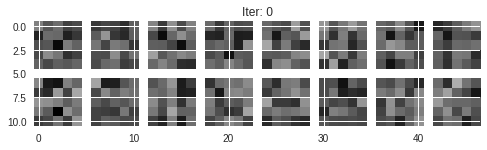

Iter: 1, loss:67.79655872099102
Iter: 2, loss:49.133196140639484
Iter: 3, loss:39.811612928286195
Iter: 4, loss:33.49623615946621
Iter: 5, loss:29.083206789102405
Iter: 6, loss:26.00382789853029
Iter: 7, loss:23.05304391379468
Iter: 8, loss:20.490096516441554
Iter: 9, loss:18.25070718023926
Iter: 10, loss:16.425834352266975
Test accuracy: 
 0.9847


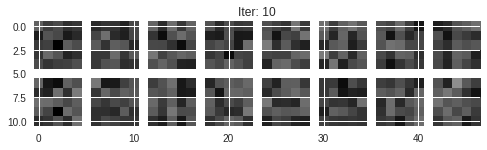

Iter: 11, loss:14.984250534675084
Iter: 12, loss:13.203497459646314
Iter: 13, loss:11.789111906080507
Iter: 14, loss:11.237463284807745
Iter: 15, loss:9.848845820844872
Iter: 16, loss:8.88705058558844
Iter: 17, loss:7.744906273932429
Iter: 18, loss:6.9608367485925555


KeyboardInterrupt: ignored

In [183]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from sklearn.metrics import accuracy_score

DATA_DIR = '/home/lmark/Documents/LabosDU/MNIST/'
SAVE_DIR = '~/home/lmark/Documents/LabosDU/out_tf/'

# Read dataset
np.random.seed(int(time.time() * 1e6) % 2**31)
dataset = input_data.read_data_sets(DATA_DIR, one_hot=True)
train_x = dataset.train.images
train_x = train_x.reshape([-1, 1, 28, 28])
train_y = dataset.train.labels
valid_x = dataset.validation.images
valid_x = valid_x.reshape([-1, 1, 28, 28])
valid_y = dataset.validation.labels
test_x = dataset.test.images
test_x = test_x.reshape([-1, 1, 28, 28])
test_y = dataset.test.labels
train_mean = train_x.mean()
train_x -= train_mean
valid_x -= train_mean
test_x -= train_mean

# GPU config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/gpu:0'):
  logits, loss, inputs, labels = build_model(np.shape(train_y)[1])
  trainer = tf.train.GradientDescentOptimizer(0.1)
  train_step = trainer.minimize(loss)
  
  tf_sess = tf.Session(config=config)
  tf_sess.run(tf.global_variables_initializer())
  
  batch_size = 100
  
  """
  Stochastic gradient descent.
  """
  #print(np.shape(X))
  # Total number of batches
  batch_count = np.shape(train_x)[0] // batch_size
  #print(batch_count)

  # Start iterations
  #print("Starting loop")
  for i in range(300):

      avg_loss = 0
      # shuffle 2 arrays at the same time
      s = np.arange(np.shape(train_x)[0])
      np.random.shuffle(s)
      X_shuffled = train_x[s]
      Y_shuffled = train_y[s]
      #print(np.shape(X_shuffled))
      #print(np.shape(X_shuffled))

      #print("Inside for1")
      # Go through all batch indices
      for batch_index in range(int(batch_count)):
          #print("Hello")
          batch_x = X_shuffled[
              batch_index * batch_size : (batch_index + 1) * batch_size]
          batch_y = Y_shuffled[
              batch_index * batch_size : (batch_index + 1) * batch_size]

          #print(np.shape(batch_x))
          #print(np.shape(batch_y))
          # Train on current batch
          _, train_logits, train_loss= tf_sess.run \
          (
              [train_step, logits, loss],
              feed_dict={inputs: batch_x, labels: batch_y}
          )
          
          avg_loss += train_loss

      # Print iteration error
      print("Iter: {}, loss:{}".format(i, avg_loss))
      
      # Check test accuracy and get weights
      if i%10 == 0:
        test_logits, _= tf_sess.run \
          (
              [logits, loss],
              feed_dict={inputs: test_x, labels: test_y}
          )
        acc = accuracy_score(
            np.argmax(test_y, axis=1), 
            np.argmax(test_logits, axis=1))
        print("Test accuracy: \n", acc)
        
        # Extract weights
        with tf.variable_scope('conv1', reuse=True) as scope_conv:
          W_conv1 = tf.get_variable('weights', shape=[5, 5, 28, 16])
          np_weights = W_conv1.eval(session=tf_sess)
        draw_conv_filters(i,10,np_weights.T)

Prediction:  2 Actual:  2
Model accuracy:  0.9826


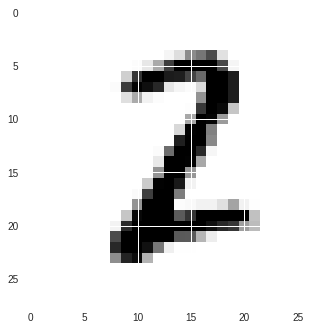

In [182]:
check_index = 256
check_logits, check_loss= tf_sess.run \
          (
              [logits, loss],
              feed_dict={inputs: [test_x[check_index]], 
                         labels: [test_y[check_index]]}
          )
print("Prediction: ", np.argmax(check_logits),
      "Actual: ", np.argmax(test_y[check_index]))
plt.imshow(test_x[check_index][0])
acc = accuracy_score(np.argmax(test_logits, axis=1), np.argmax(test_y, axis=1))
print("Model accuracy: ", acc)

4. zadatak - Klasifikacija na CIFAR-10 skupu

CIFAR-10 dataset sastoji se od 50000 slika za učenje i validaciju te 10000 slika za testiranje dimenzija 32x32 podijeljenih u 10 razreda. Najprije skinite dataset pripremljen za Python ovdje. Iskorisite sljedeći kod kako biste učitali podatke i pripremili ih.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cifar-10-python.tar.gz to cifar-10-python.tar (2).gz


In [201]:
!tar -xvzf cifar-10-python.tar\ \(1\).gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
import os
import pickle
import numpy as np

def shuffle_data(data_x, data_y):
  indices = np.arange(data_x.shape[0])
  np.random.shuffle(indices)
  shuffled_data_x = np.ascontiguousarray(data_x[indices])
  shuffled_data_y = np.ascontiguousarray(data_y[indices])
  return shuffled_data_x, shuffled_data_y

def unpickle(file):
  fo = open(file, 'rb')
  dict = pickle.load(fo, encoding='latin1')
  fo.close()
  return dict

DATA_DIR = 'cifar-10-batches-py'

img_height = 32
img_width = 32
num_channels = 3

train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
  subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
  train_x = np.vstack((train_x, subset['data']))
  train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std


In [0]:
train_y_oh = np.zeros((np.shape(train_y)[0], 10))
valid_y_oh = np.zeros((np.shape(valid_y)[0], 10))
test_y_oh = np.zeros((np.shape(test_y)[0], 10))

for i, y_ in enumerate(train_y):
  train_y_oh[i][y_] = 1
  
for i, y_ in enumerate(valid_y):
  valid_y_oh[i][y_] = 1
  
for i, y_ in enumerate(test_y):
  test_y_oh[i][y_] = 1

In [0]:
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt

def build_model_zad4(num_classes, weight_decay_ = 1e-5):
  tf.reset_default_graph()
  
  # Initialize weight decay
  weight_decay = weight_decay_
  
  conv1sz = 16 # Output count - 1. layer - CONV
  conv2sz = 32 # Output count - 2. layer - CONV
  
  fc3sz = 256  # Output count - 3. layer - FC
  fc4sz = 128  # Output count - 4. layer - FC
  fc5sz = 10   # Output count - 5. layer - FC
  
  inputs = tf.placeholder(tf.float32, [None, 32, 32, 3], name="inputs")
  labels = tf.placeholder(tf.float32, [None, num_classes], name="labels")

  # Conv part ...
  with tf.contrib.framework.arg_scope([layers.conv2d],
      kernel_size=5, stride=2, padding='SAME', activation_fn=tf.nn.relu,
      weights_initializer=layers.variance_scaling_initializer(),
      weights_regularizer=layers.l2_regularizer(weight_decay)):
    
    conv1_out = layers.conv2d(inputs, conv1sz, scope='conv1')
    relu1_out = tf.nn.relu(conv1_out, name='relu1')
    pool1_out = layers.max_pool2d(relu1_out, kernel_size=3, 
                                  stride=2, scope='pool1', padding='SAME')
    
    conv2_out = layers.conv2d(pool1_out, conv2sz, scope='conv2')
    relu2_out = tf.nn.relu(conv2_out, name='relu2')
    pool2_out = layers.max_pool2d(relu2_out, kernel_size=3, 
                                  stride=2, scope='pool2', padding='SAME')
    
  # FC part ...
  with tf.contrib.framework.arg_scope([layers.fully_connected],
      activation_fn=tf.nn.relu,
      weights_initializer=layers.variance_scaling_initializer(),
      weights_regularizer=layers.l2_regularizer(weight_decay)):

    # sada definiramo potpuno povezane slojeve
    # ali najprije prebacimo 4D tenzor u matricu
    flatten3_out = layers.flatten(pool2_out)
    
    fc3_out = layers.fully_connected(flatten3_out, fc3sz, scope='fc3')
    relu3_out = tf.nn.relu(fc3_out, name='relu3')
    
    fc4_out = layers.fully_connected(relu3_out, fc4sz, scope='fc4')
    relu4_out = tf.nn.relu(fc4_out, name='relu4')
    
    fc5_out = layers.fully_connected(relu4_out, fc5sz, scope='fc5')
    relu5_out = tf.nn.relu(fc5_out, name='relu5')
    
  logits = layers.fully_connected(relu5_out, num_classes, 
                                  activation_fn=None, scope='logits')
  loss = tf.losses.softmax_cross_entropy(labels, logits)

  return logits, loss, inputs, labels

def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'training_plot.pdf')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)


Iter: 0, loss:402.7967777252197
Valid accuracy:0.2436 

Plotting in:  /training_plot.pdf


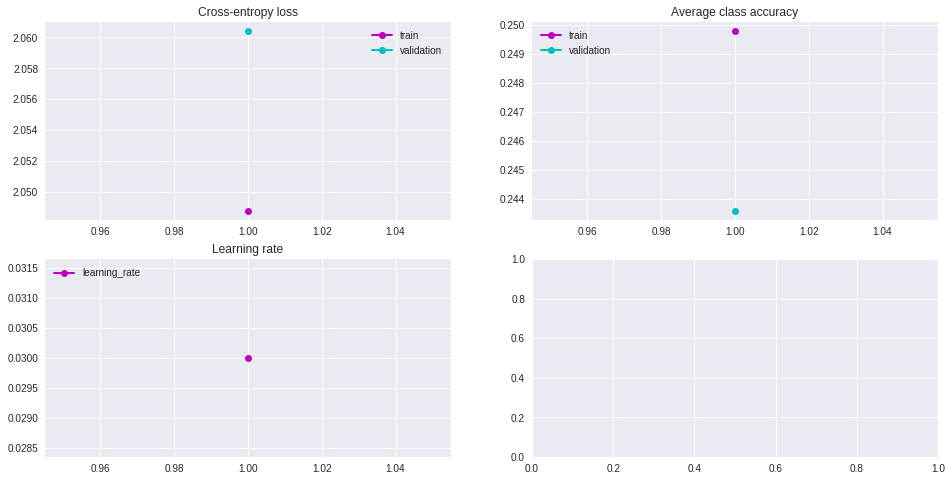

Learning rate:  0.03


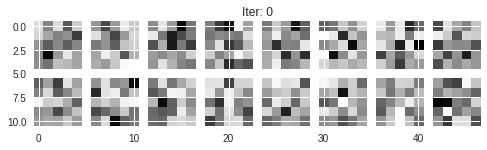

Iter: 1, loss:347.2469004392624
Valid accuracy:0.3068 

Plotting in:  /training_plot.pdf


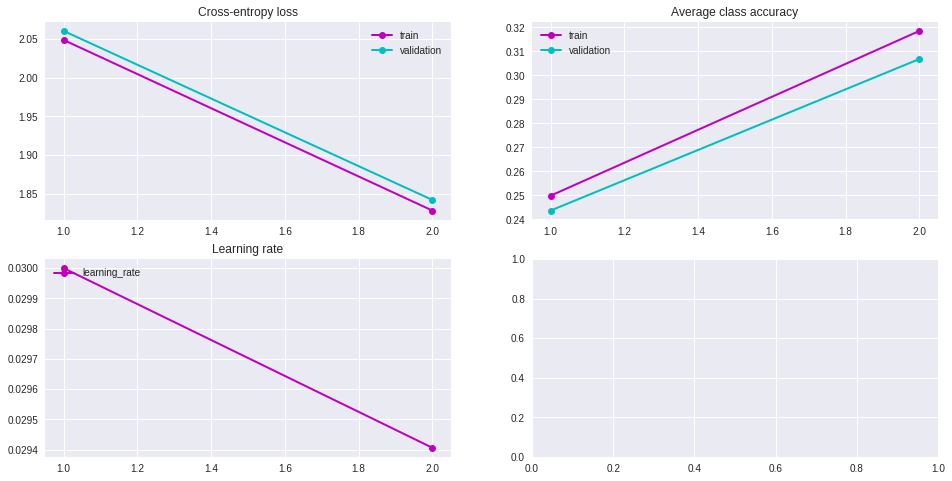

Iter: 2, loss:315.88883113861084
Valid accuracy:0.3726 

Plotting in:  /training_plot.pdf


Iter: 3, loss:298.5657101869583
Valid accuracy:0.4114 

Plotting in:  /training_plot.pdf


Iter: 4, loss:278.7739497423172
Valid accuracy:0.4096 

Plotting in:  /training_plot.pdf


Iter: 5, loss:259.76992785930634
Valid accuracy:0.4672 

Plotting in:  /training_plot.pdf


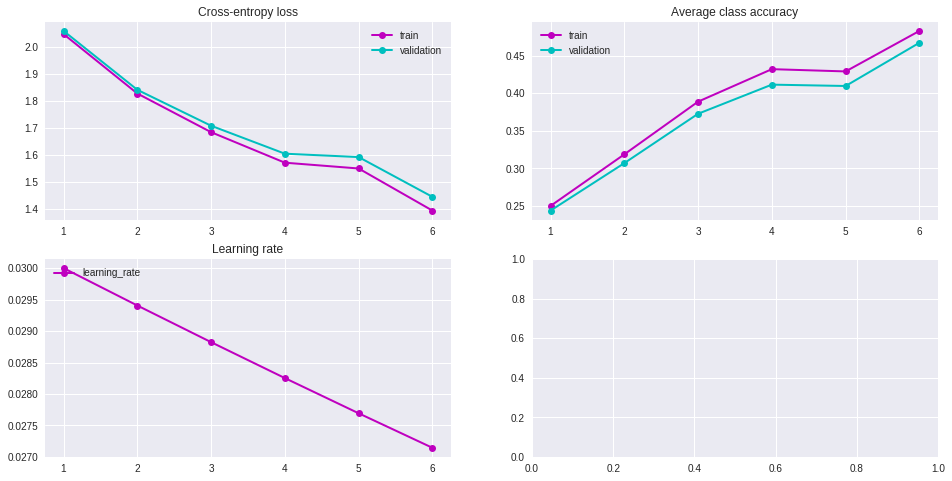

Iter: 6, loss:245.94634699821472
Valid accuracy:0.4902 

Plotting in:  /training_plot.pdf


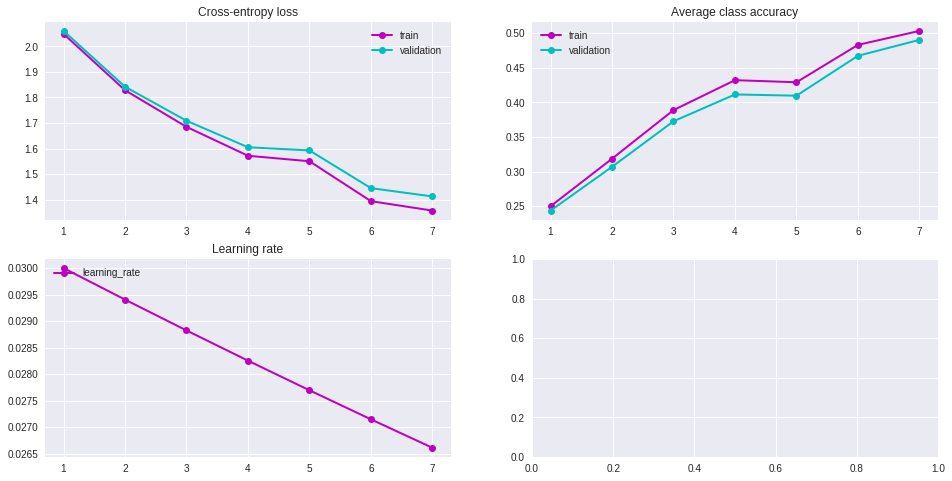

Iter: 7, loss:234.16595840454102
Valid accuracy:0.5176 

Plotting in:  /training_plot.pdf


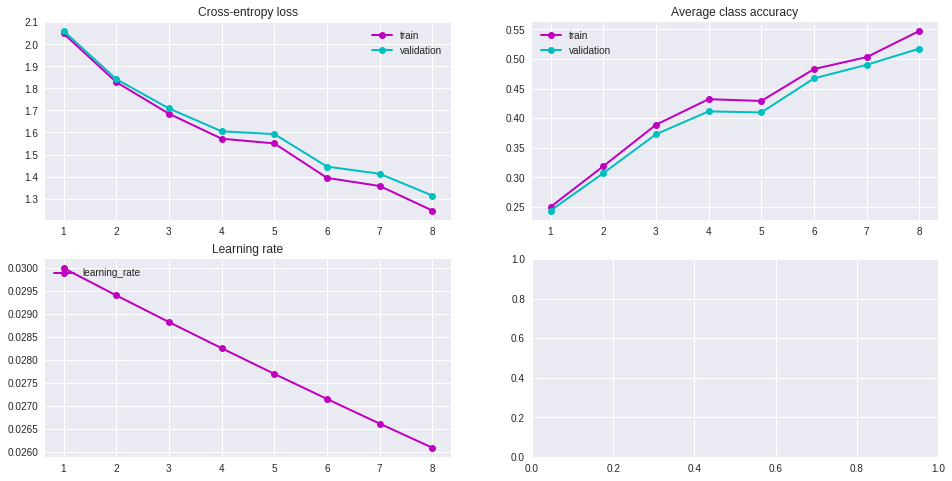

Iter: 8, loss:225.4532378911972
Valid accuracy:0.529 

Plotting in:  /training_plot.pdf


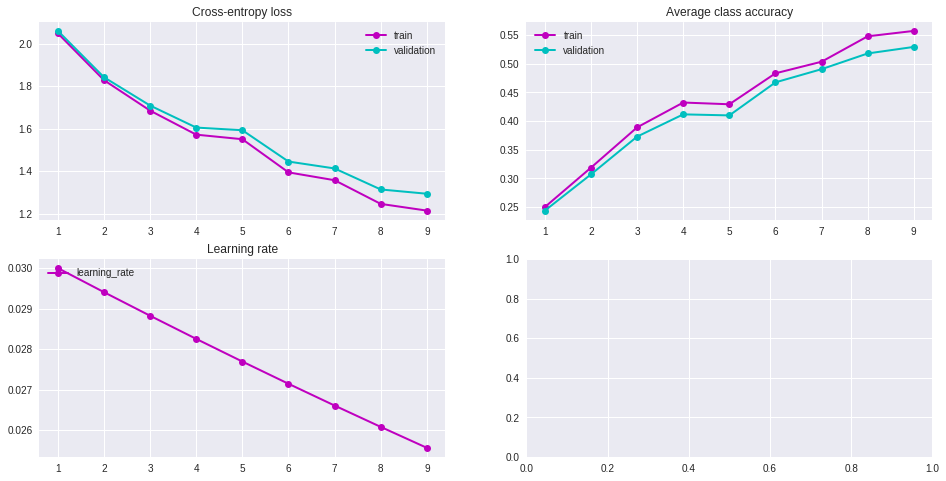

Iter: 9, loss:217.31098806858063
Valid accuracy:0.533 

Plotting in:  /training_plot.pdf


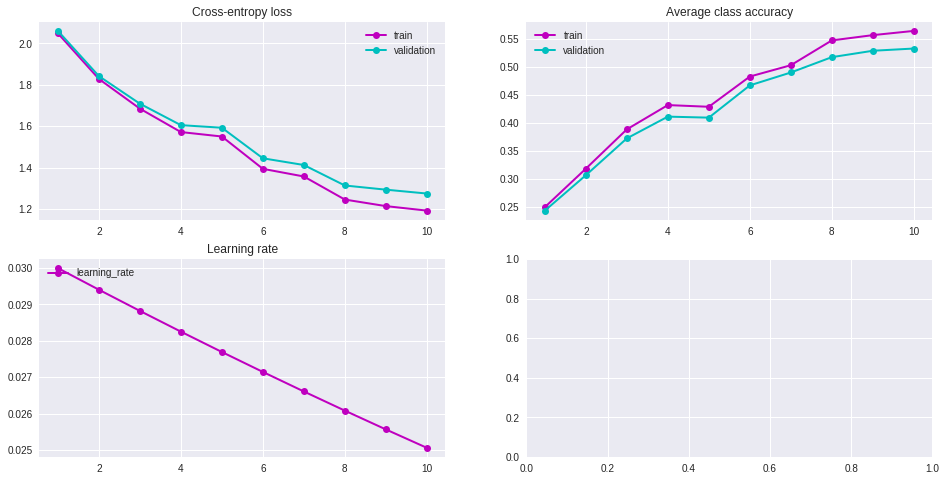

Iter: 10, loss:212.02783155441284
Valid accuracy:0.5512 

Plotting in:  /training_plot.pdf


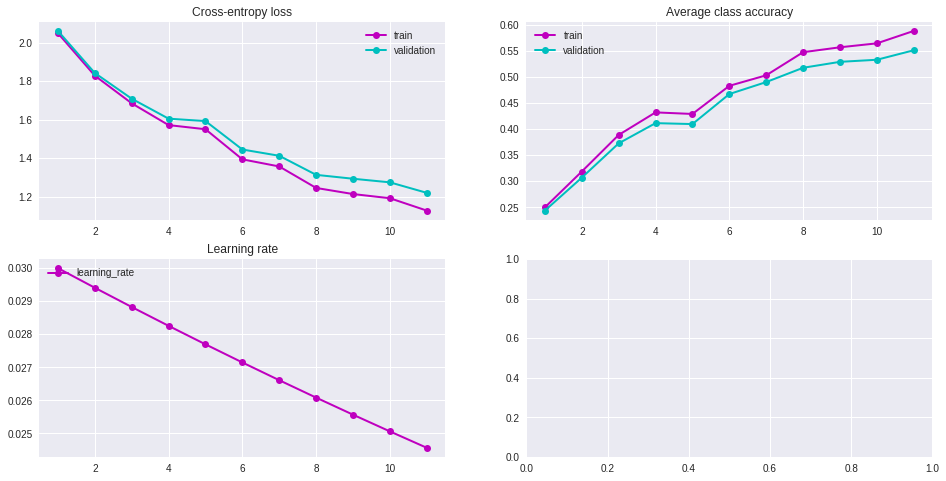

Learning rate:  0.024561922592339455


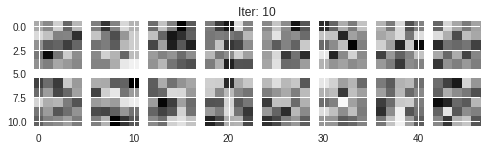

Iter: 11, loss:206.5754817724228
Valid accuracy:0.5502 

Plotting in:  /training_plot.pdf


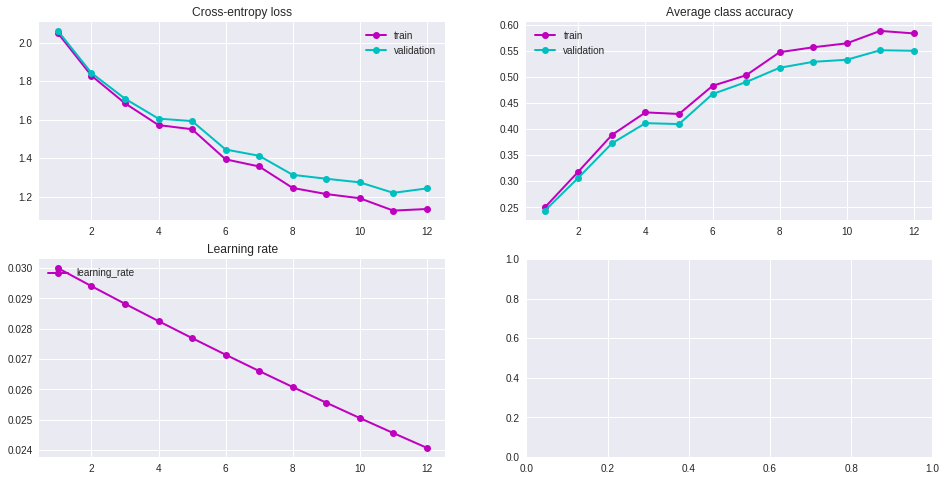

Iter: 12, loss:201.93602645397186
Valid accuracy:0.5754 

Plotting in:  /training_plot.pdf


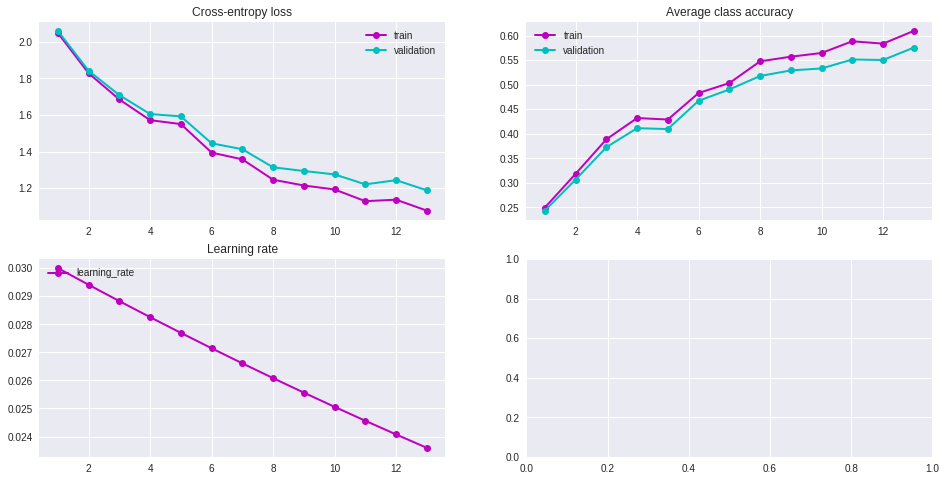

Iter: 13, loss:197.2669422030449
Valid accuracy:0.5666 

Plotting in:  /training_plot.pdf


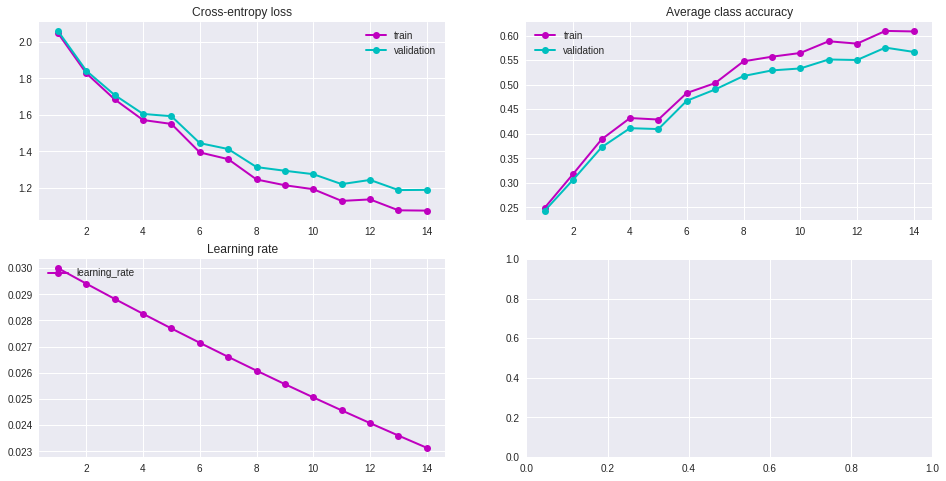

Iter: 14, loss:194.0692639350891
Valid accuracy:0.576 

Plotting in:  /training_plot.pdf


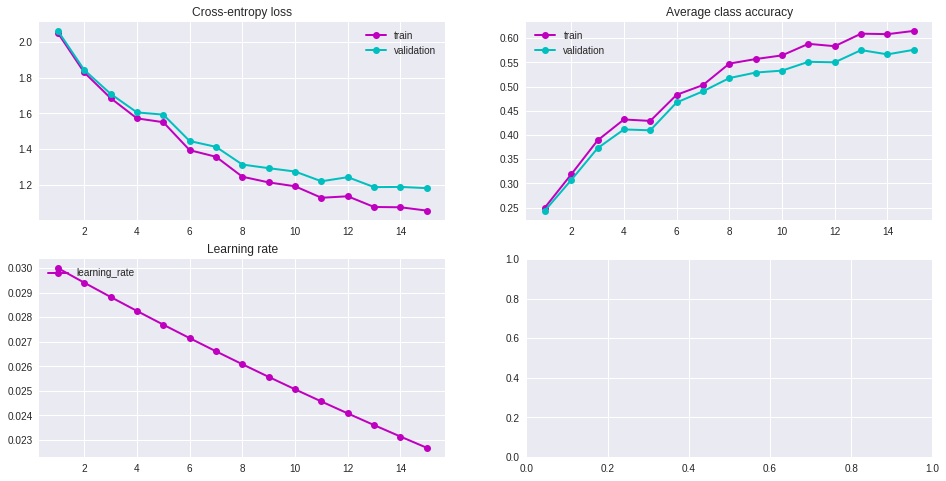

Iter: 15, loss:190.49129021167755
Valid accuracy:0.5808 

Plotting in:  /training_plot.pdf


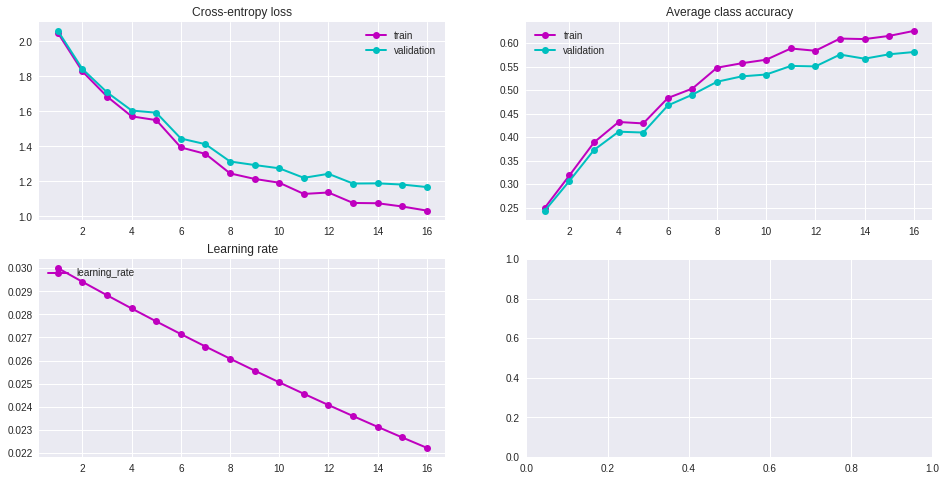

Iter: 16, loss:187.1347200870514
Valid accuracy:0.5896 

Plotting in:  /training_plot.pdf


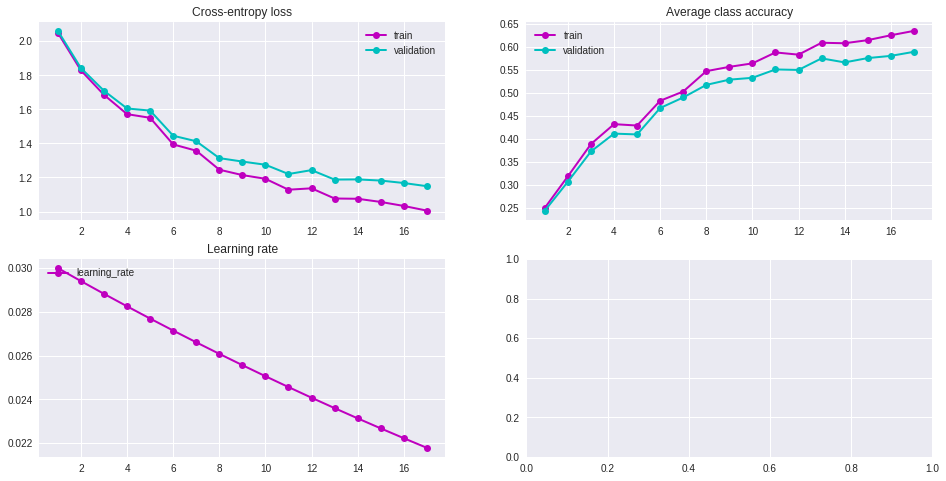

Iter: 17, loss:183.96918666362762
Valid accuracy:0.583 

Plotting in:  /training_plot.pdf


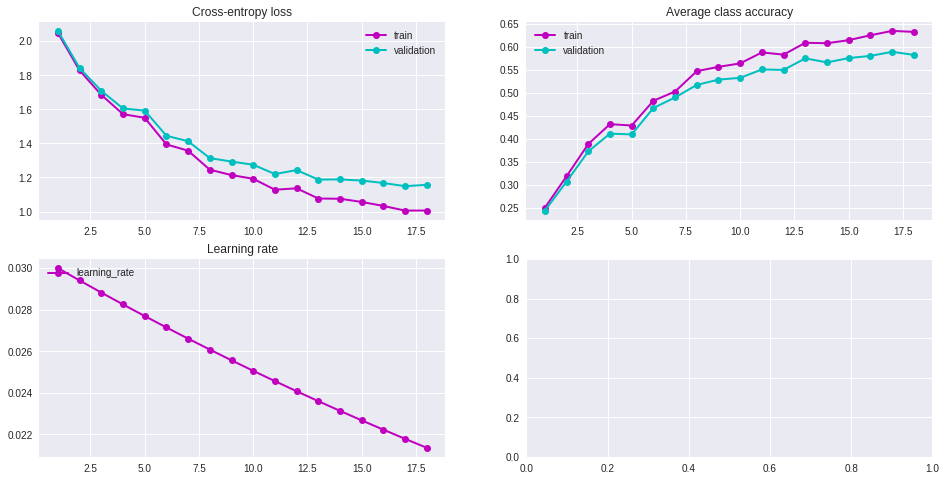

Iter: 18, loss:181.58111560344696
Valid accuracy:0.5996 

Plotting in:  /training_plot.pdf


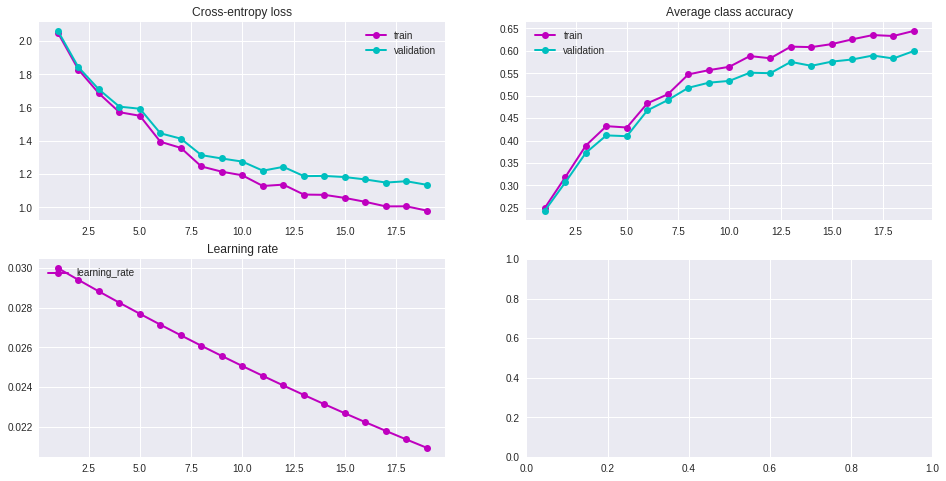

Iter: 19, loss:178.6153101325035
Valid accuracy:0.5944 

Plotting in:  /training_plot.pdf


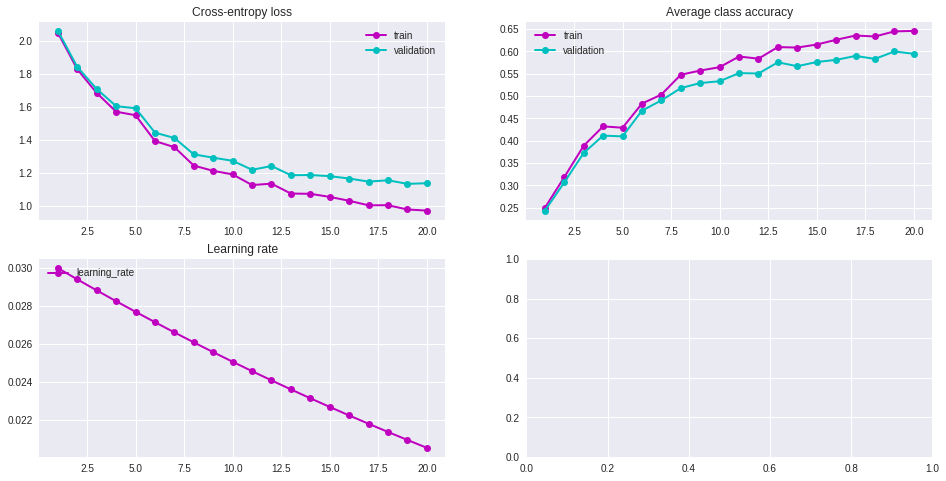

Iter: 20, loss:176.25088769197464
Valid accuracy:0.5952 

Plotting in:  /training_plot.pdf


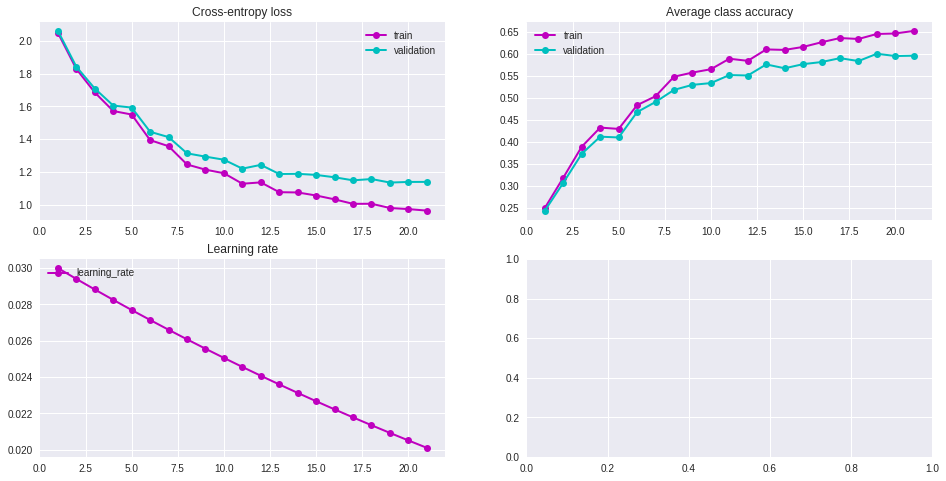

Learning rate:  0.020109601381069177


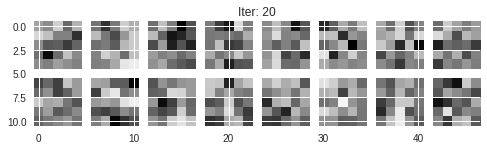

Iter: 21, loss:173.88217306137085
Valid accuracy:0.5982 

Plotting in:  /training_plot.pdf


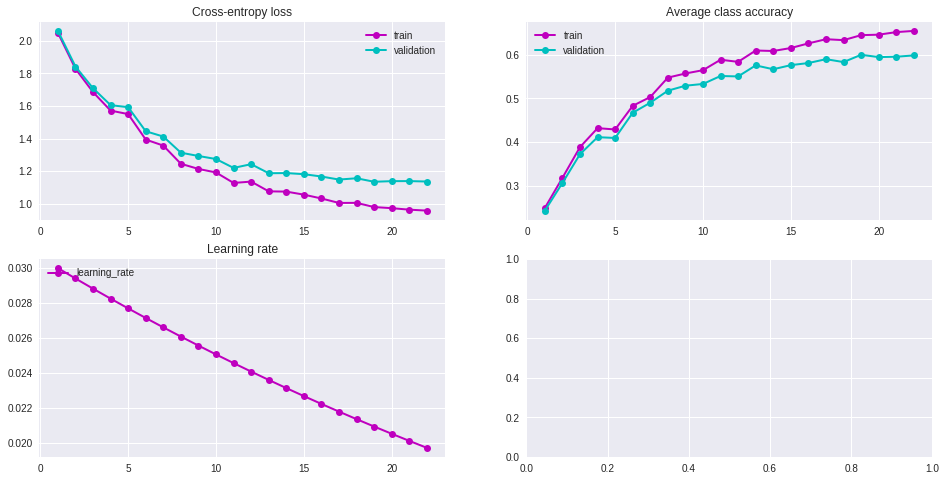

Iter: 22, loss:171.36029320955276
Valid accuracy:0.6088 

Plotting in:  /training_plot.pdf


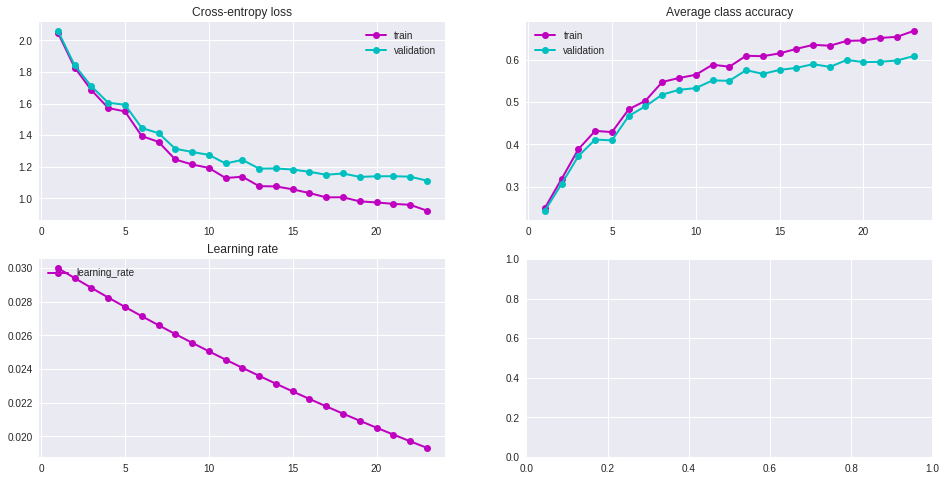

Iter: 23, loss:168.82032918930054
Valid accuracy:0.6068 

Plotting in:  /training_plot.pdf


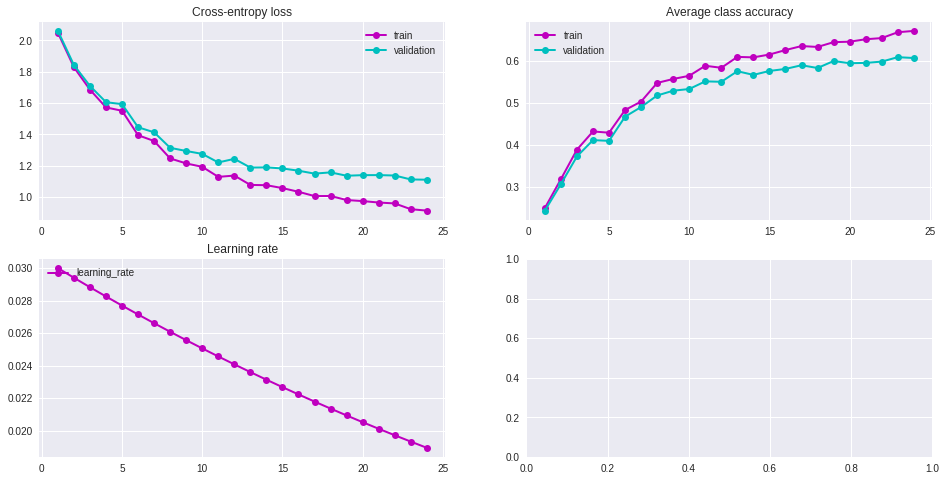

Iter: 24, loss:166.82011604309082
Valid accuracy:0.5936 

Plotting in:  /training_plot.pdf


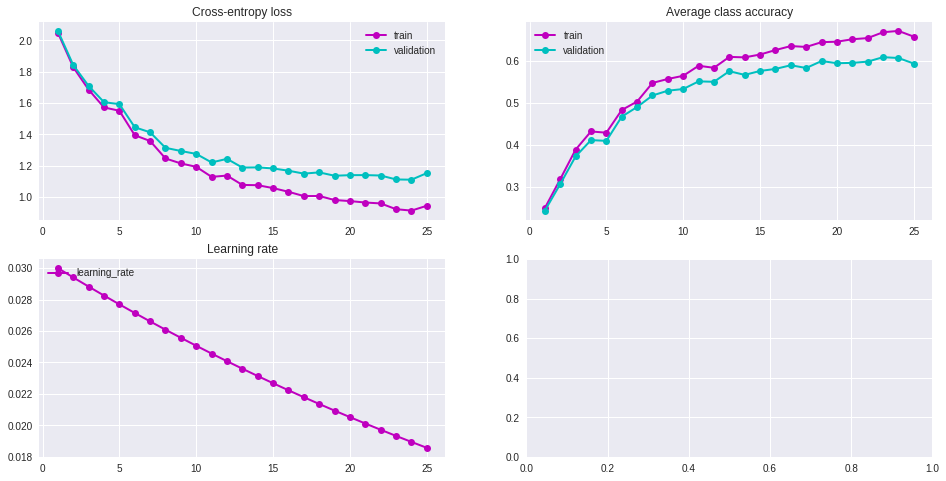

Iter: 25, loss:165.02044820785522
Valid accuracy:0.607 

Plotting in:  /training_plot.pdf


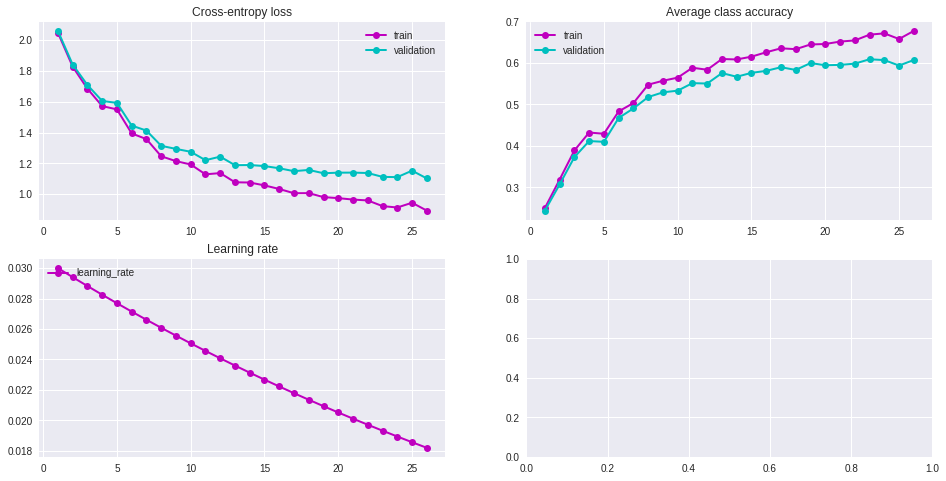

Iter: 26, loss:162.6445181965828
Valid accuracy:0.6076 

Plotting in:  /training_plot.pdf


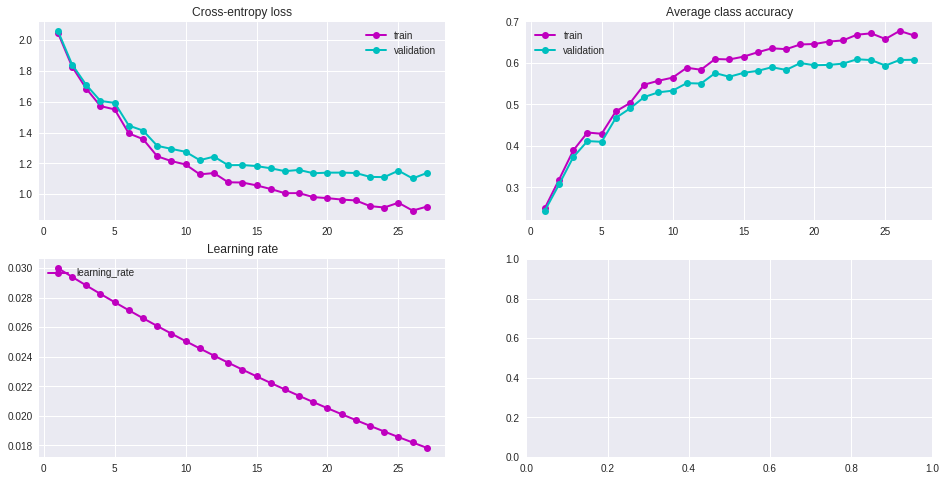

Iter: 27, loss:161.4193405508995
Valid accuracy:0.611 

Plotting in:  /training_plot.pdf


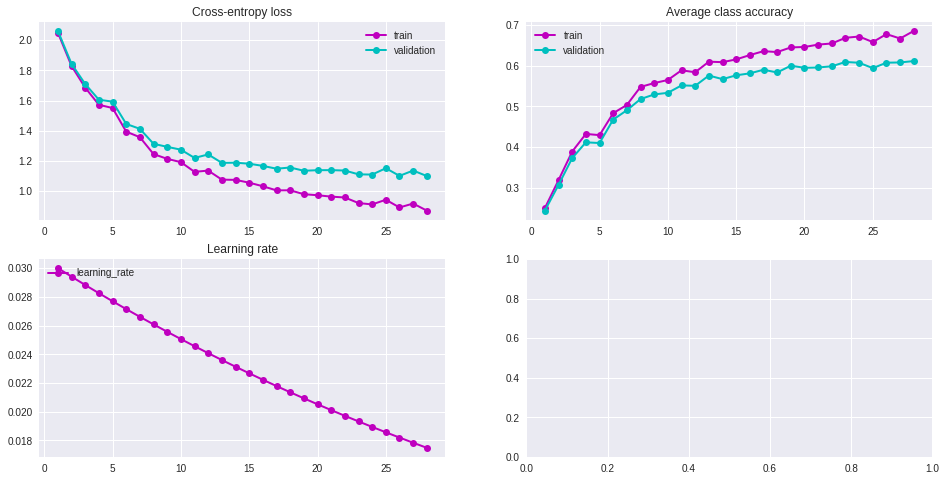

Iter: 28, loss:159.548714697361
Valid accuracy:0.613 

Plotting in:  /training_plot.pdf


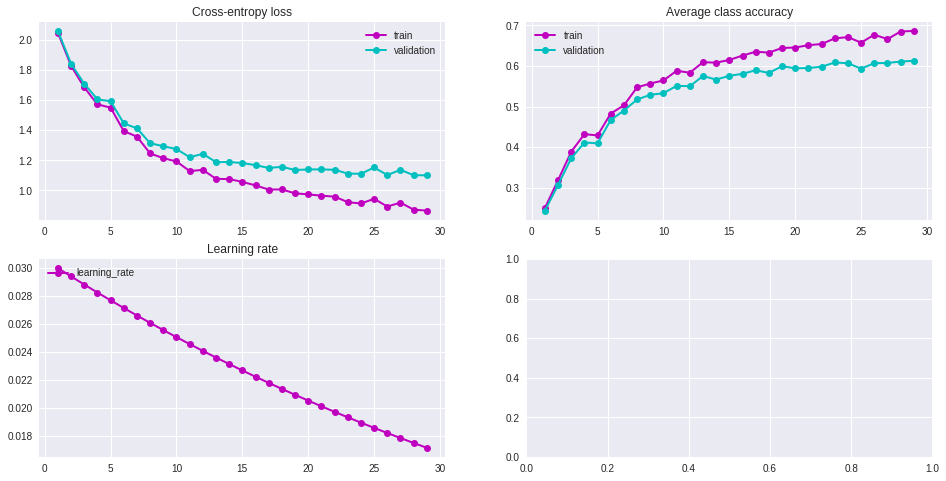

Iter: 29, loss:157.6312073469162
Valid accuracy:0.6164 

Plotting in:  /training_plot.pdf


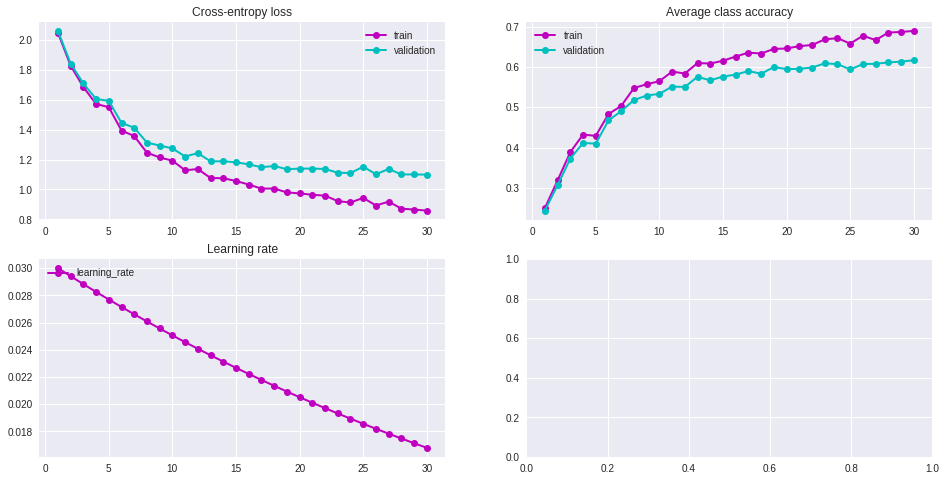

Iter: 30, loss:156.2727922797203
Valid accuracy:0.6092 

Plotting in:  /training_plot.pdf


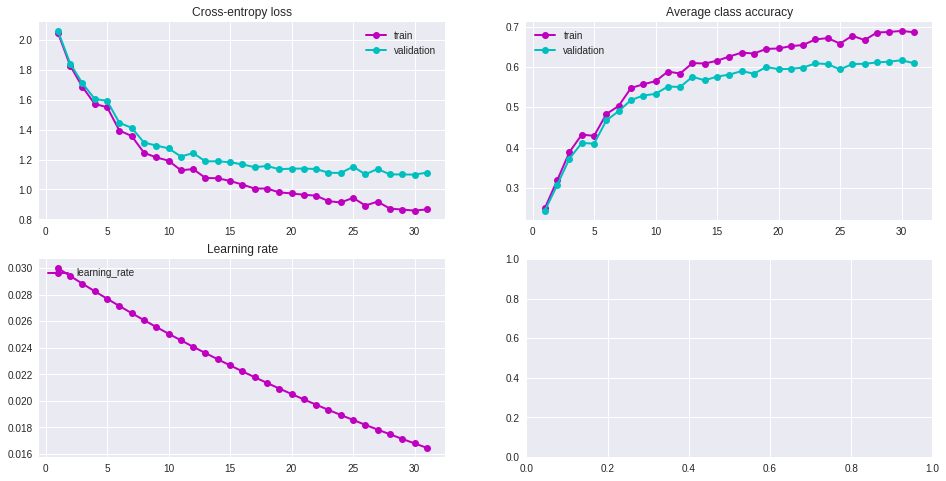

Learning rate:  0.01646434908282079


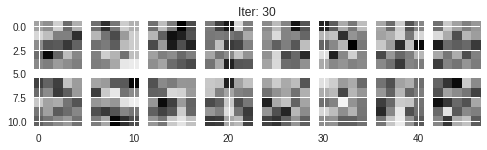

Iter: 31, loss:154.53932934999466
Valid accuracy:0.6176 

Plotting in:  /training_plot.pdf


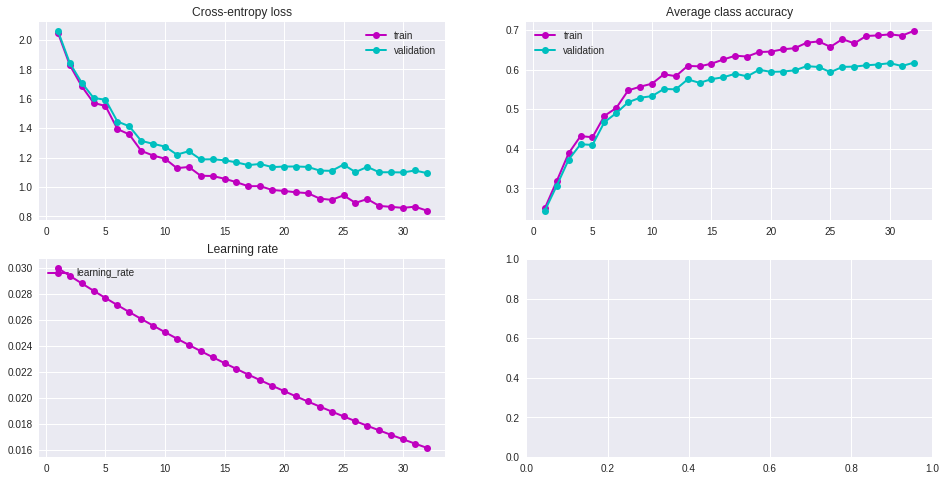

Iter: 32, loss:153.00618720054626
Valid accuracy:0.6168 

Plotting in:  /training_plot.pdf


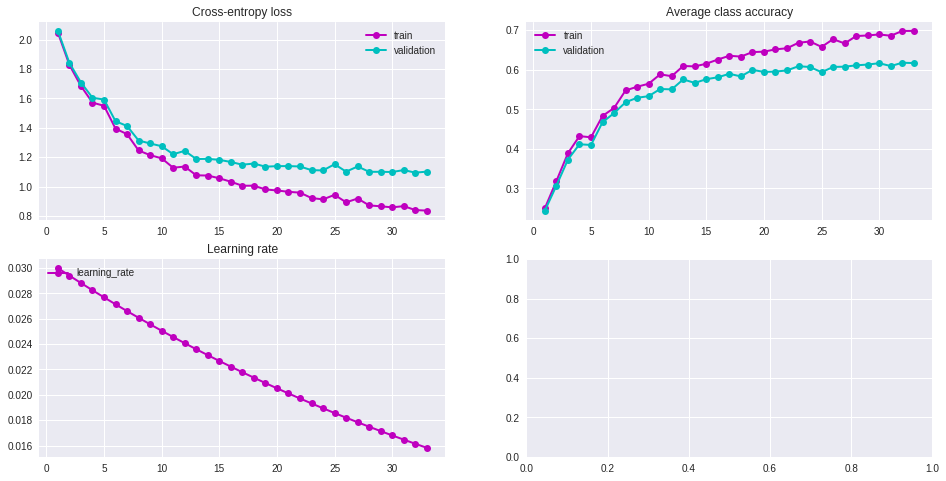

Iter: 33, loss:151.9930534362793
Valid accuracy:0.6168 

Plotting in:  /training_plot.pdf


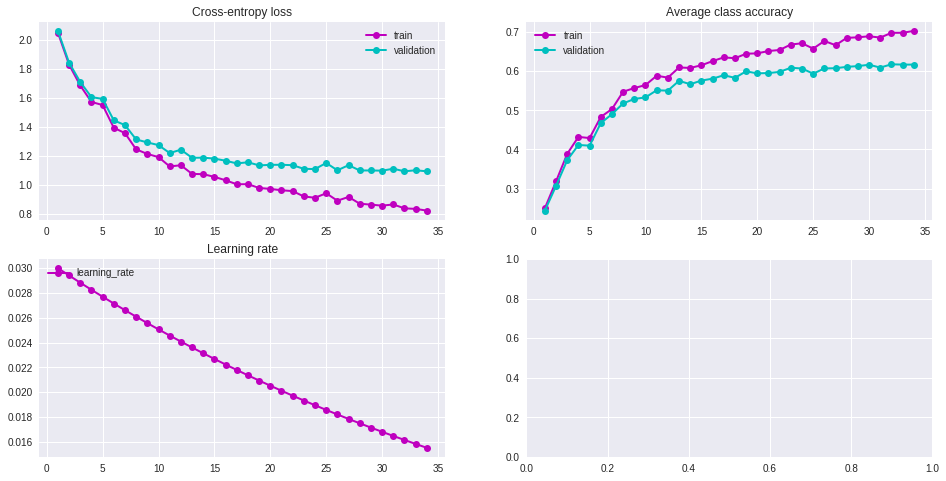

Iter: 34, loss:150.07637292146683
Valid accuracy:0.6172 

Plotting in:  /training_plot.pdf


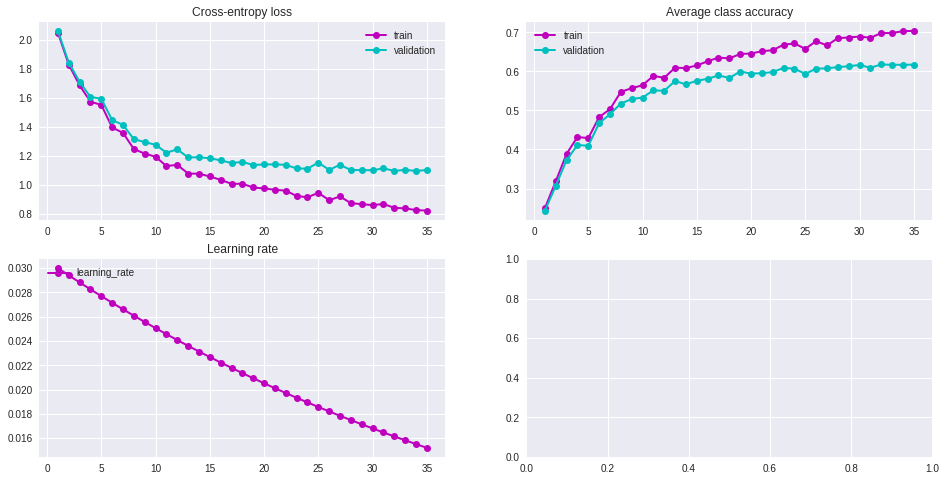

Iter: 35, loss:149.0061692595482
Valid accuracy:0.6238 

Plotting in:  /training_plot.pdf


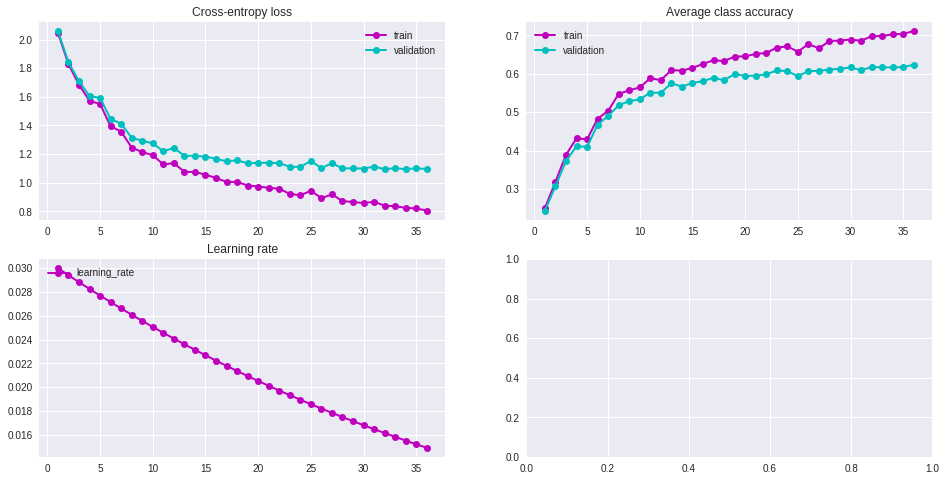

Iter: 36, loss:147.50516909360886
Valid accuracy:0.6176 

Plotting in:  /training_plot.pdf


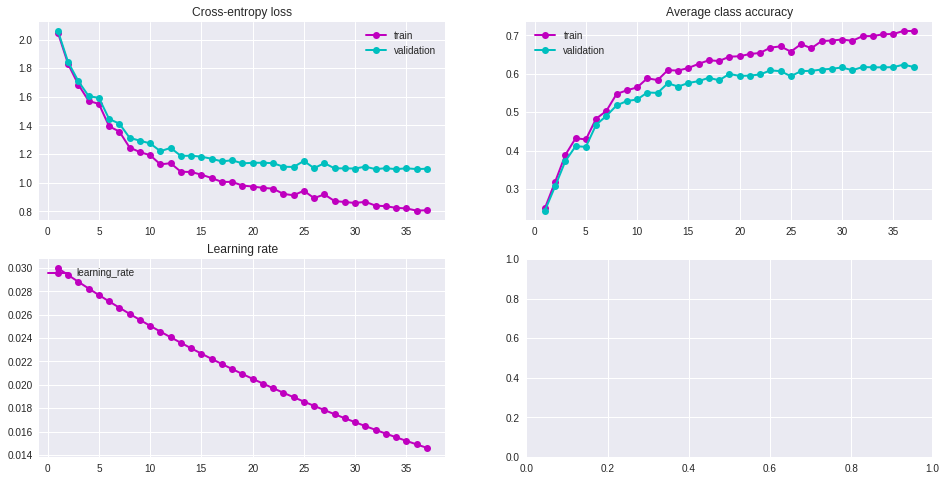

Iter: 37, loss:146.26818132400513
Valid accuracy:0.6212 

Plotting in:  /training_plot.pdf


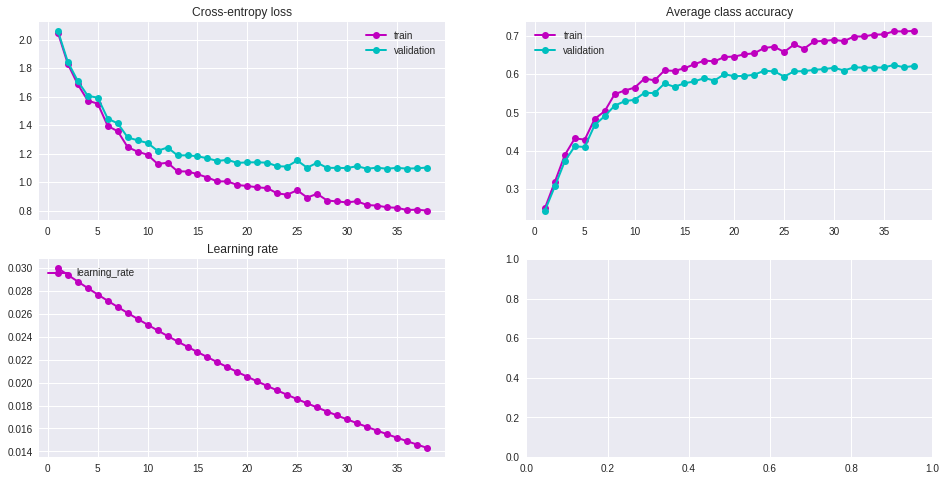

Iter: 38, loss:145.33914053440094
Valid accuracy:0.618 

Plotting in:  /training_plot.pdf


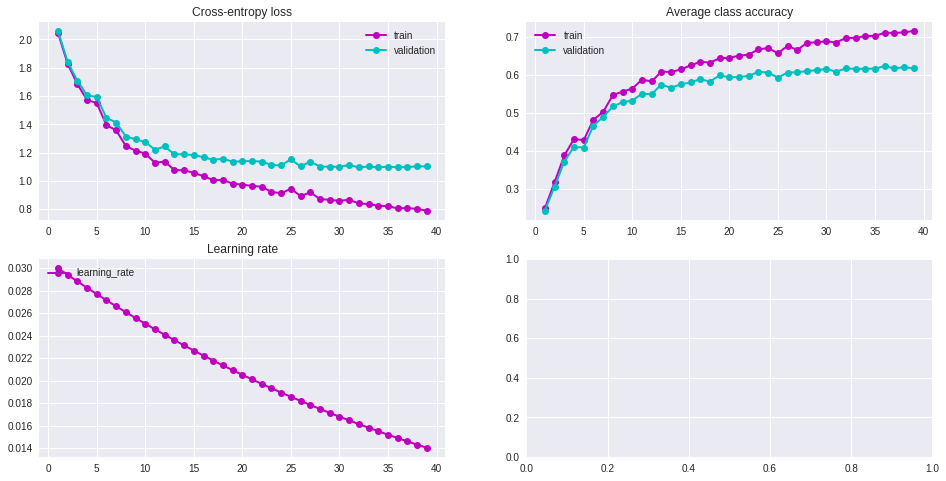

Iter: 39, loss:143.93611699342728
Valid accuracy:0.6222 

Plotting in:  /training_plot.pdf


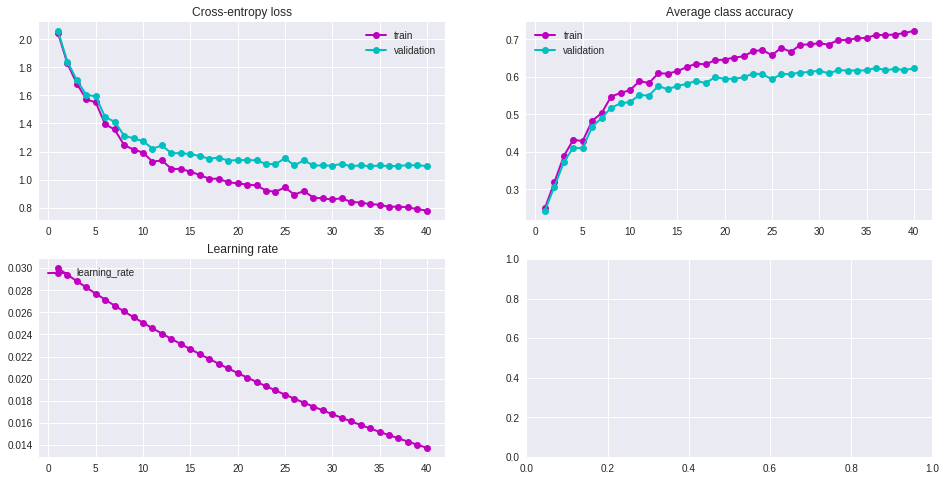

Iter: 40, loss:142.68765103816986
Valid accuracy:0.6192 

Plotting in:  /training_plot.pdf


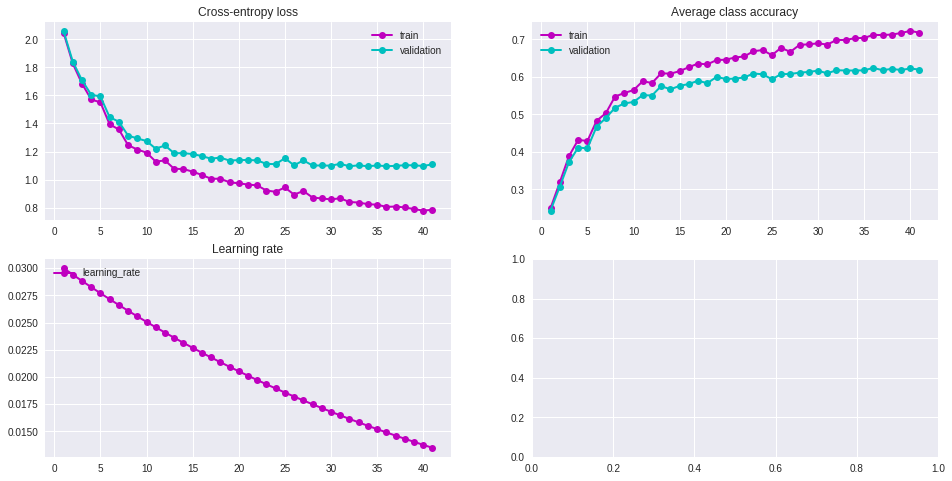

Learning rate:  0.013479868923516646


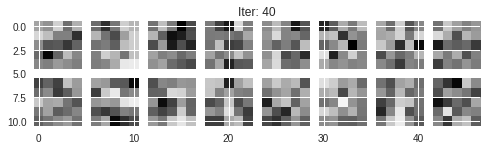

Iter: 41, loss:141.64168840646744
Valid accuracy:0.616 

Plotting in:  /training_plot.pdf


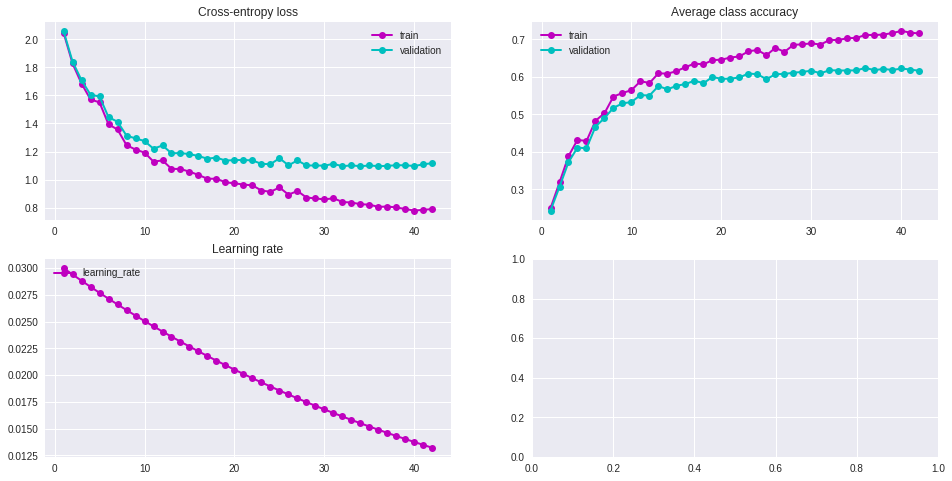

Iter: 42, loss:140.77089089155197
Valid accuracy:0.6188 

Plotting in:  /training_plot.pdf


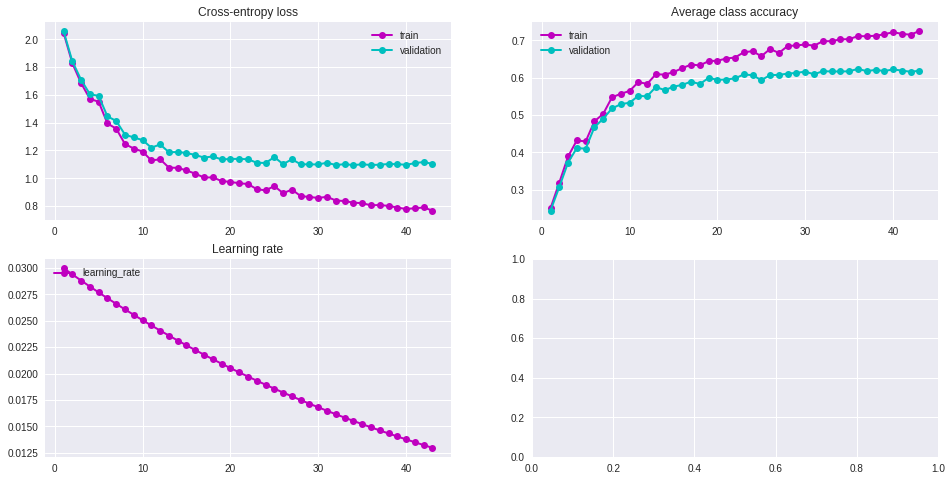

Iter: 43, loss:139.57341080904007
Valid accuracy:0.6254 

Plotting in:  /training_plot.pdf


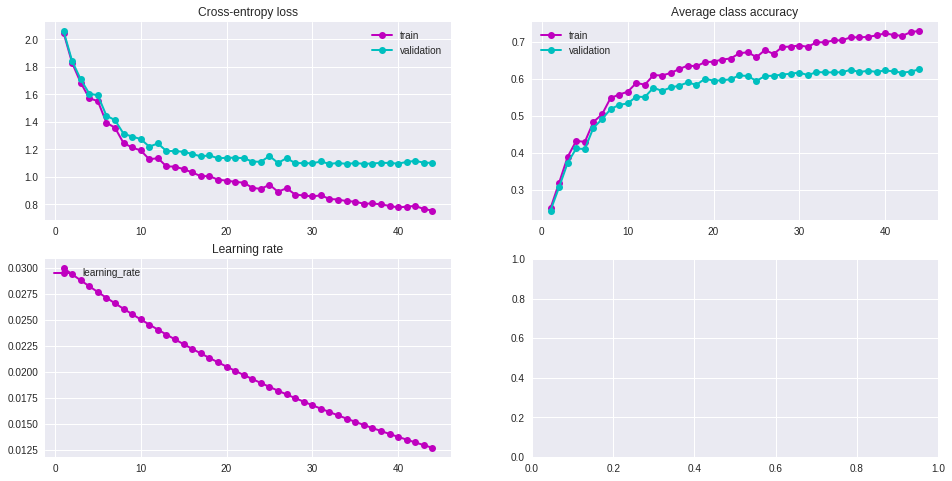

Iter: 44, loss:138.29897737503052
Valid accuracy:0.619 

Plotting in:  /training_plot.pdf


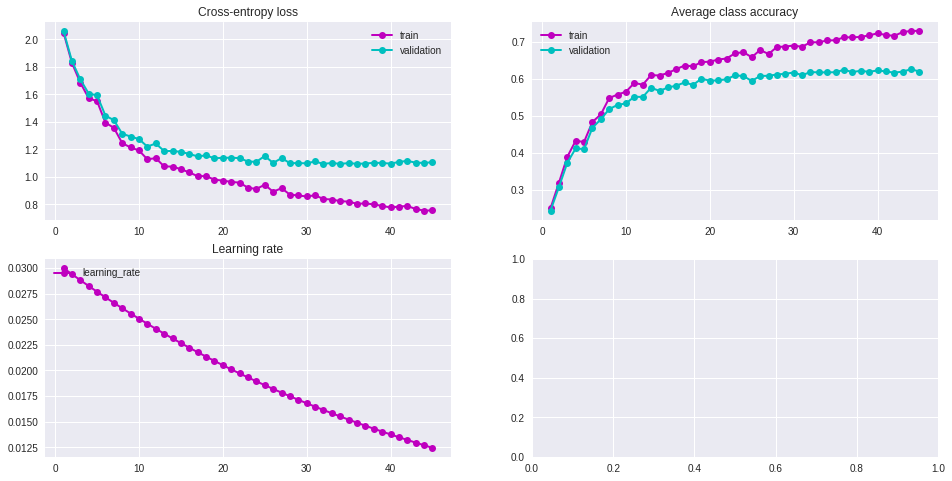

Iter: 45, loss:137.54689621925354
Valid accuracy:0.623 

Plotting in:  /training_plot.pdf


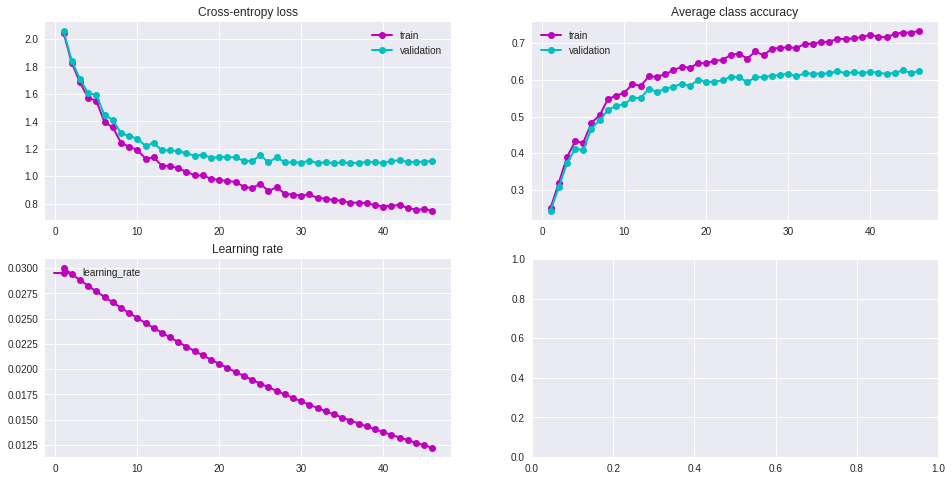

Iter: 46, loss:136.4074079990387
Valid accuracy:0.6202 

Plotting in:  /training_plot.pdf


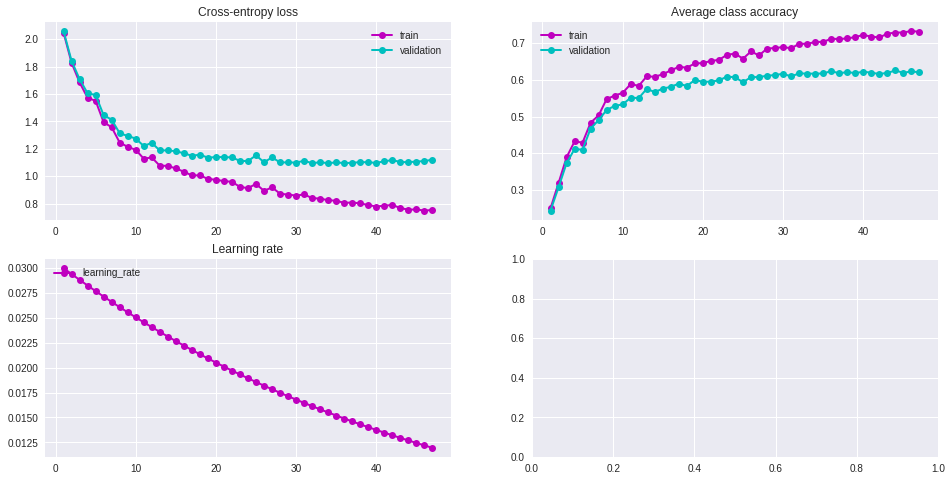

Iter: 47, loss:135.6335551738739
Valid accuracy:0.6238 

Plotting in:  /training_plot.pdf


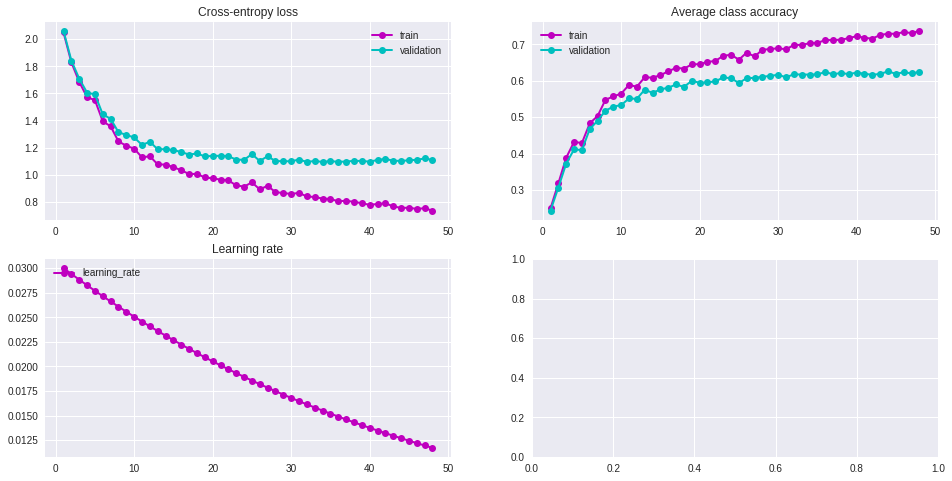

Iter: 48, loss:134.6949879527092
Valid accuracy:0.6234 

Plotting in:  /training_plot.pdf


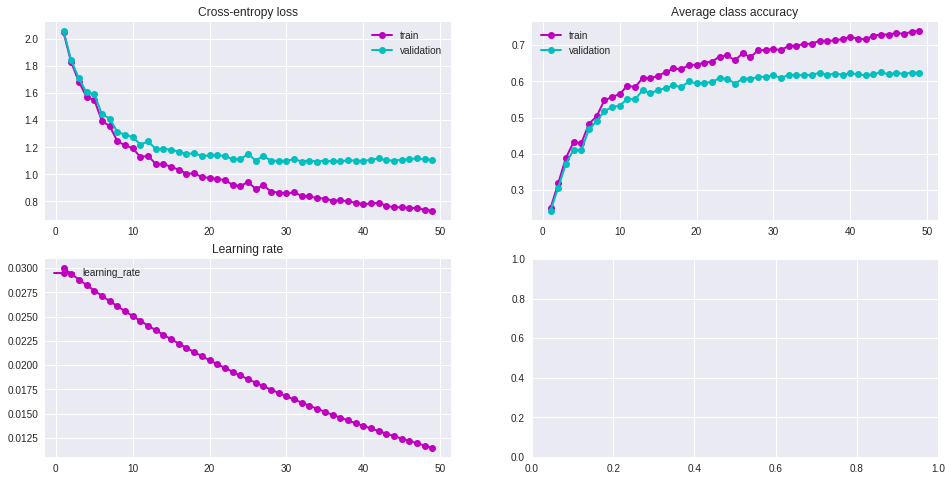

Iter: 49, loss:133.70852571725845
Valid accuracy:0.6252 

Plotting in:  /training_plot.pdf


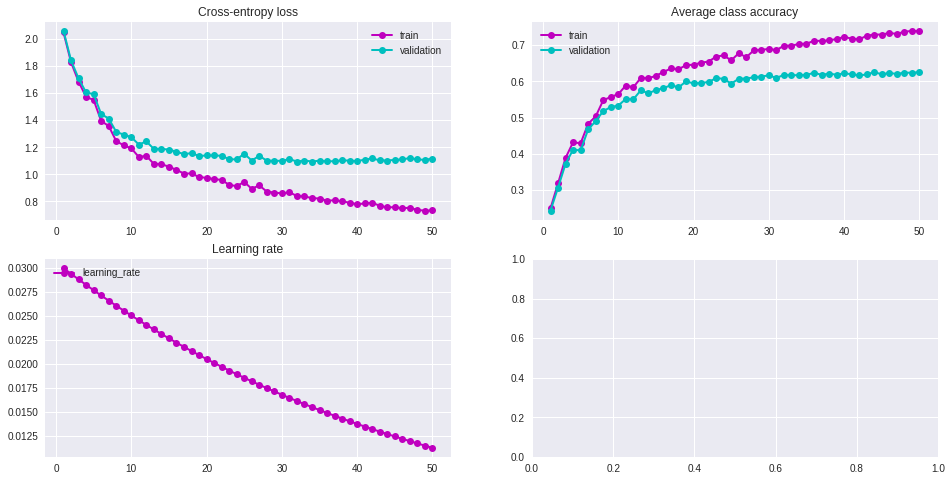

Iter: 50, loss:132.95972430706024
Valid accuracy:0.62 

Plotting in:  /training_plot.pdf


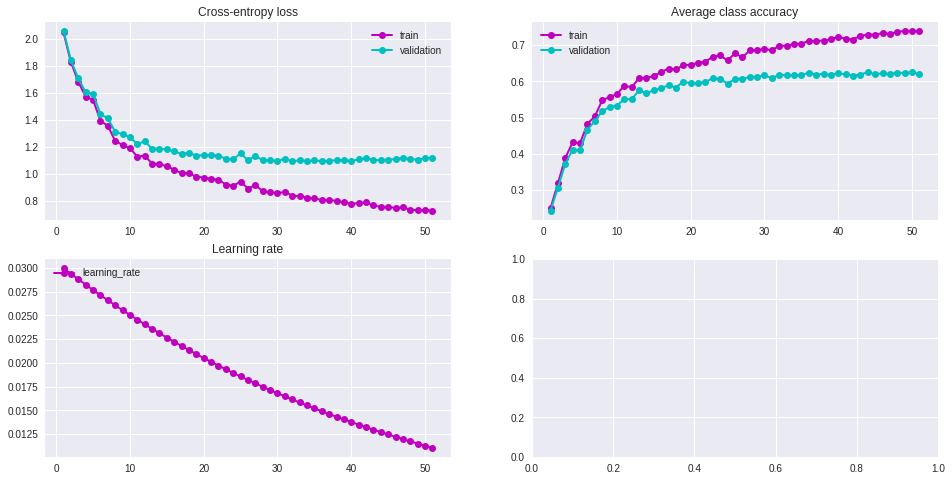

Learning rate:  0.01103638323514327


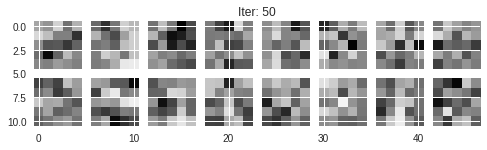

Iter: 51, loss:132.20748394727707
Valid accuracy:0.6242 

Plotting in:  /training_plot.pdf


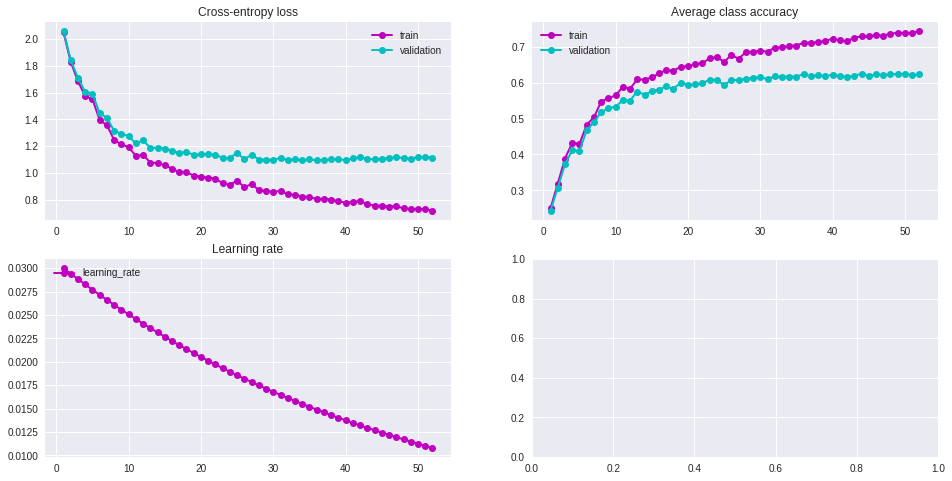

Iter: 52, loss:131.3672617673874
Valid accuracy:0.6224 

Plotting in:  /training_plot.pdf


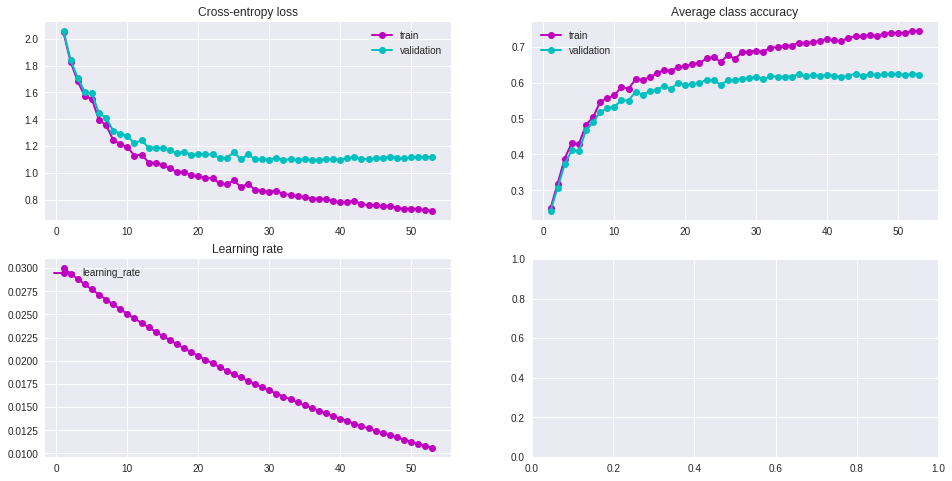

Iter: 53, loss:130.59125649929047
Valid accuracy:0.6196 

Plotting in:  /training_plot.pdf


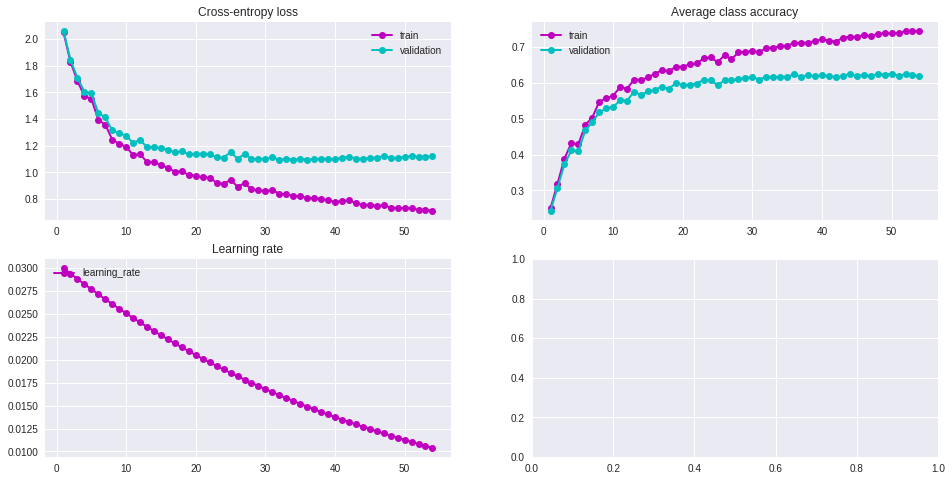

Iter: 54, loss:129.7825145125389
Valid accuracy:0.6238 

Plotting in:  /training_plot.pdf


Iter: 55, loss:129.10750192403793
Valid accuracy:0.617 

Plotting in:  /training_plot.pdf


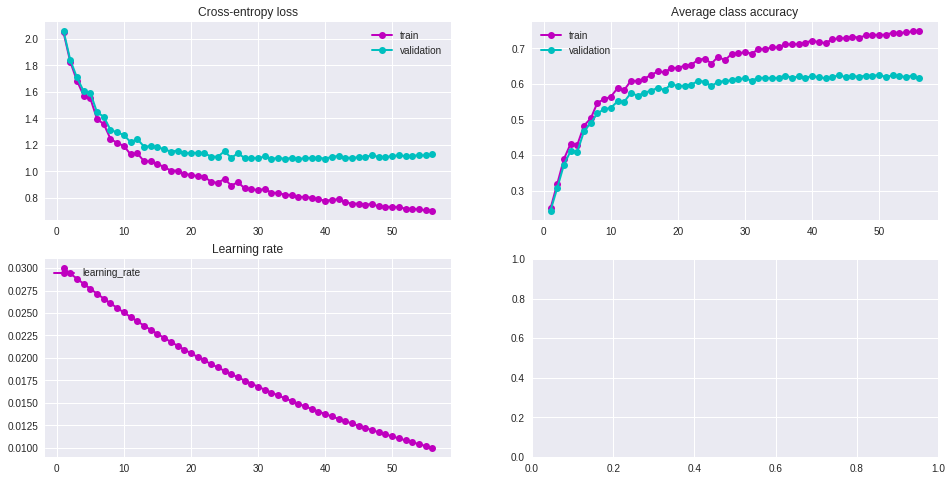

Iter: 56, loss:128.39386808872223
Valid accuracy:0.623 

Plotting in:  /training_plot.pdf


Iter: 57, loss:127.72457331418991
Valid accuracy:0.6238 

Plotting in:  /training_plot.pdf


Iter: 58, loss:126.91123139858246
Valid accuracy:0.624 

Plotting in:  /training_plot.pdf


Iter: 59, loss:126.23655760288239
Valid accuracy:0.6212 

Plotting in:  /training_plot.pdf


Iter: 60, loss:125.73022502660751
Valid accuracy:0.6234 

Plotting in:  /training_plot.pdf


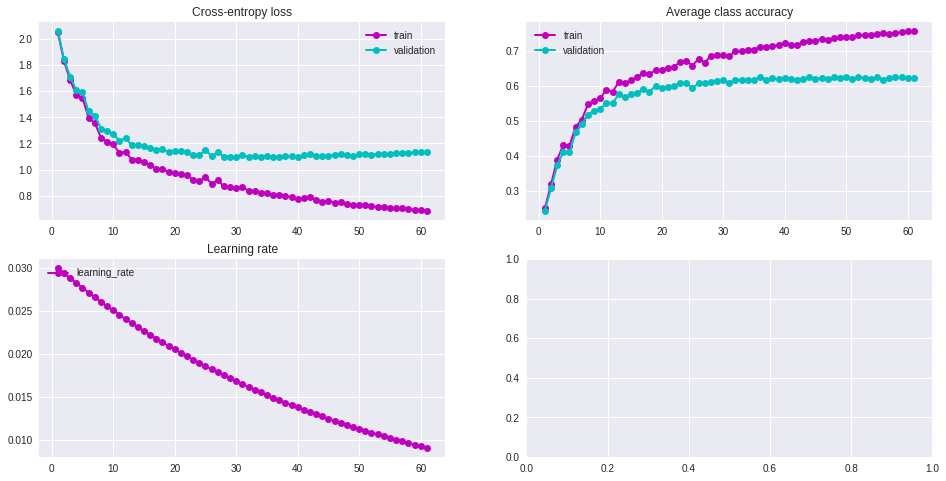

Learning rate:  0.009035826357366064


Iter: 61, loss:124.97871834039688
Valid accuracy:0.622 

Plotting in:  /training_plot.pdf


Iter: 62, loss:124.3677077293396
Valid accuracy:0.6246 

Plotting in:  /training_plot.pdf


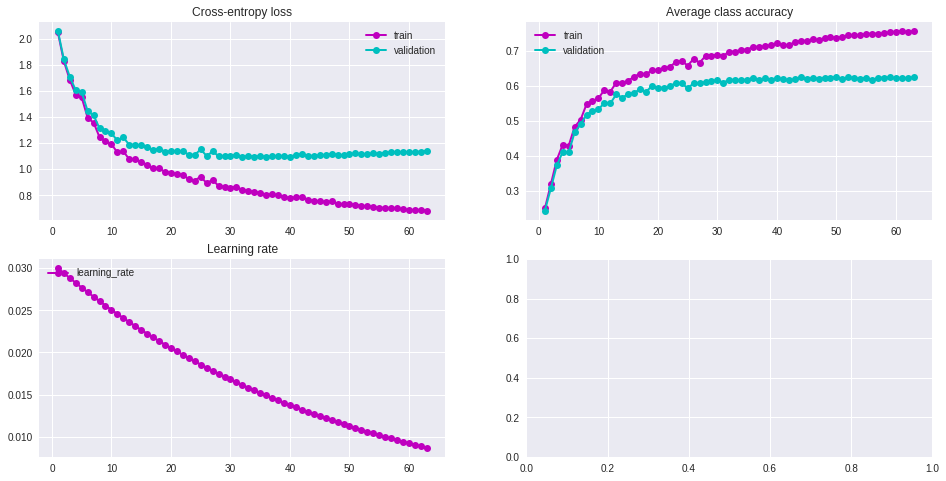

Iter: 63, loss:123.71978229284286
Valid accuracy:0.6226 

Plotting in:  /training_plot.pdf


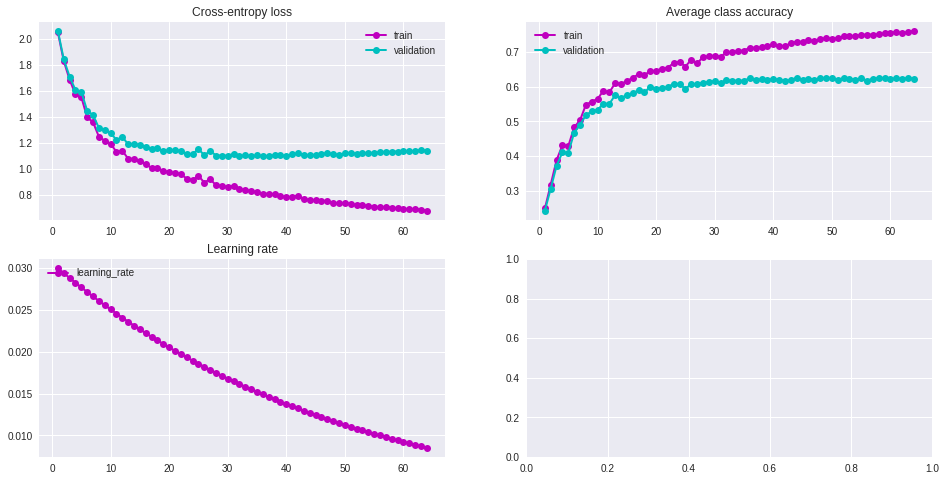

Iter: 64, loss:123.17842921614647
Valid accuracy:0.6212 

Plotting in:  /training_plot.pdf


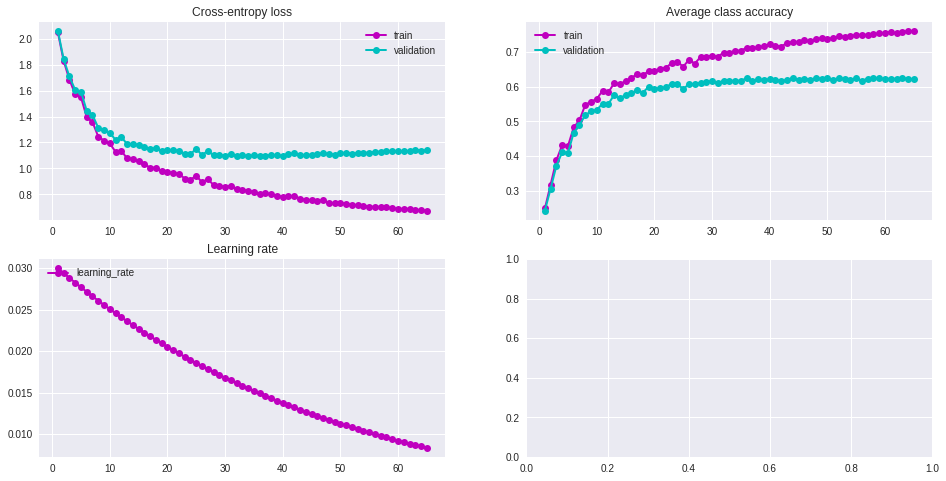

Iter: 65, loss:122.65004259347916
Valid accuracy:0.6252 

Plotting in:  /training_plot.pdf


Iter: 66, loss:122.11947691440582
Valid accuracy:0.6238 

Plotting in:  /training_plot.pdf


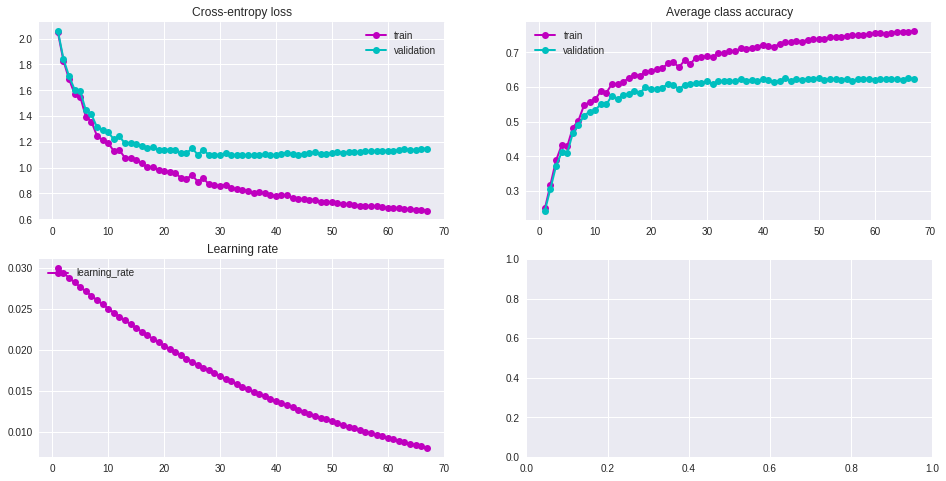

Iter: 67, loss:121.49300628900528
Valid accuracy:0.6236 

Plotting in:  /training_plot.pdf


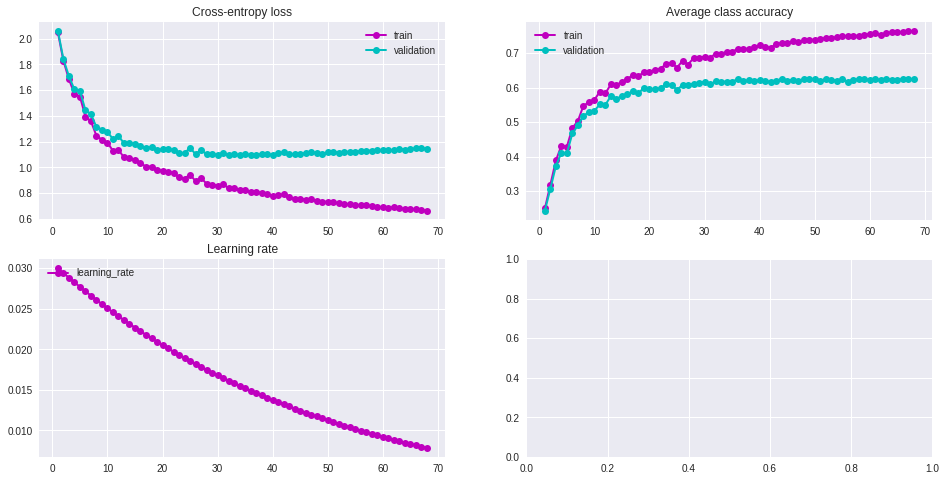

Iter: 68, loss:120.95515984296799
Valid accuracy:0.6234 

Plotting in:  /training_plot.pdf


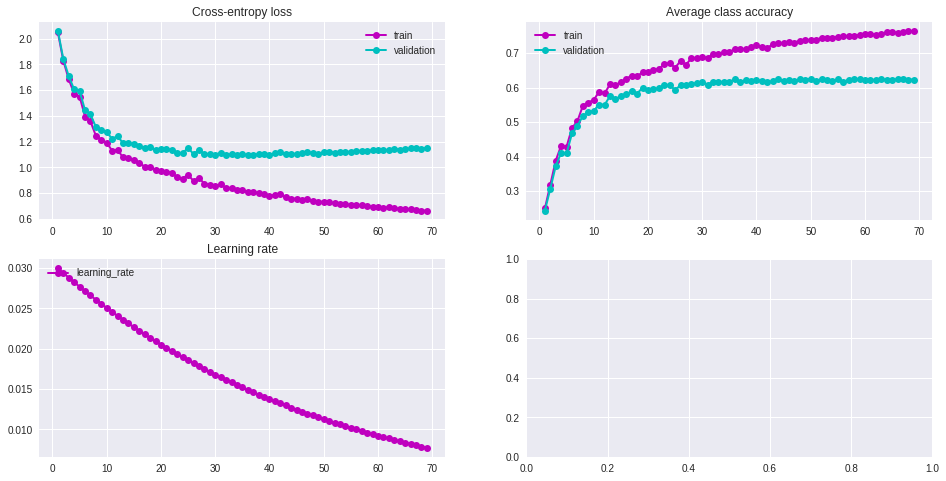

Iter: 69, loss:120.42999869585037
Valid accuracy:0.6248 

Plotting in:  /training_plot.pdf


Iter: 70, loss:119.88939702510834
Valid accuracy:0.6236 

Plotting in:  /training_plot.pdf


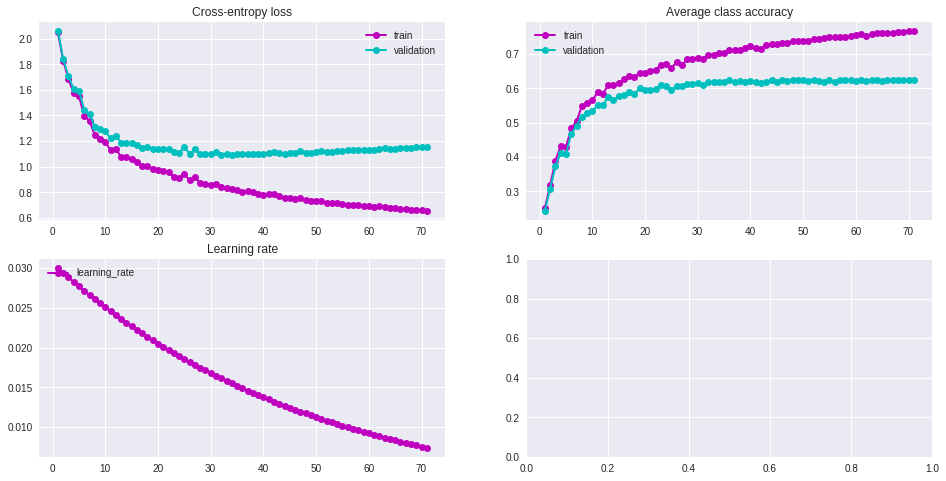

Learning rate:  0.007397908918248193


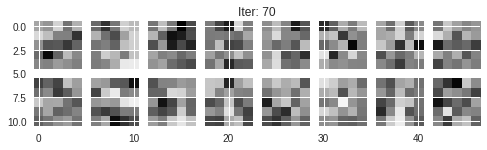

Iter: 71, loss:119.43920683860779
Valid accuracy:0.6236 

Plotting in:  /training_plot.pdf


Iter: 72, loss:118.9434170126915
Valid accuracy:0.6184 

Plotting in:  /training_plot.pdf


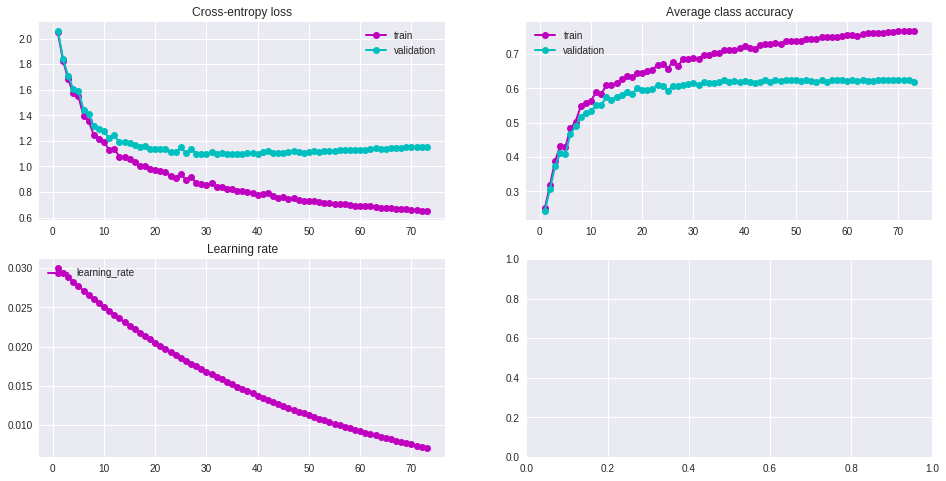

Iter: 73, loss:118.50028777122498
Valid accuracy:0.6206 

Plotting in:  /training_plot.pdf


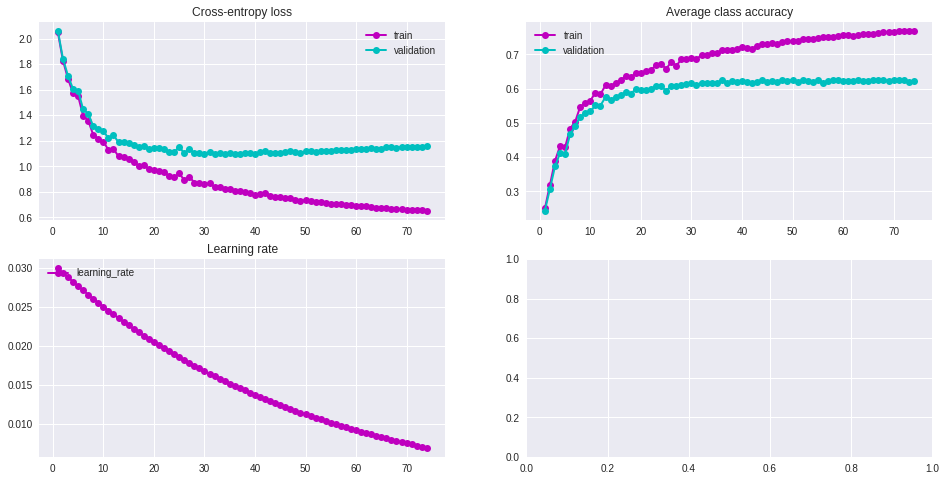

Iter: 74, loss:118.16339665651321
Valid accuracy:0.6244 

Plotting in:  /training_plot.pdf


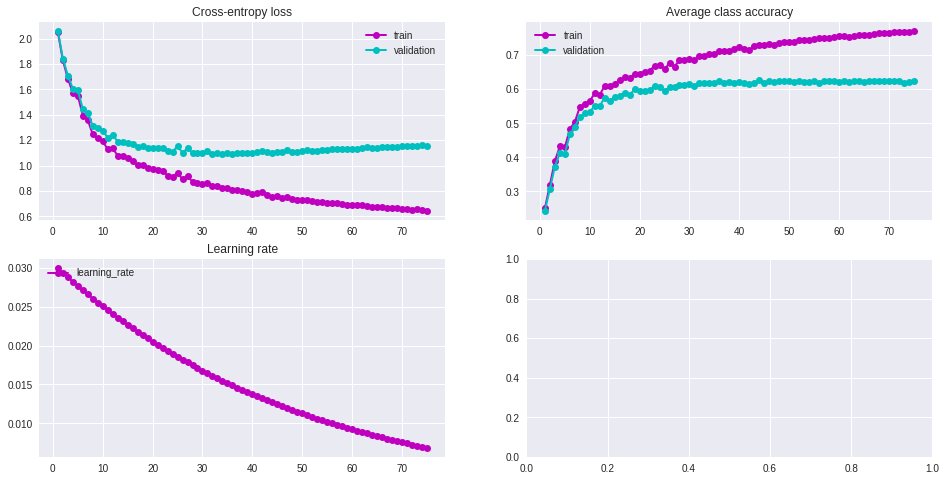

Iter: 75, loss:117.58223423361778
Valid accuracy:0.6242 

Plotting in:  /training_plot.pdf


KeyboardInterrupt: ignored

In [140]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
import math

# GPU config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/gpu:0'):
  logits, loss, inputs, labels = build_model_zad4(np.shape(train_y_oh)[1], weight_decay_=1e-3)
  
  plot_data = {}
  plot_data['train_loss'] = []
  plot_data['valid_loss'] = []
  plot_data['train_acc'] = []
  plot_data['valid_acc'] = []
  plot_data['lr'] = []

  # Decayed step ADAM optimizer
  learning_rate = tf.placeholder(tf.float32, shape=[])
  trainer = tf.train.AdagradOptimizer(learning_rate)
  train_step = trainer.minimize(loss)
  
  tf_sess = tf.Session(config=config)
  tf_sess.run(tf.global_variables_initializer())
  
  batch_size = 250
  
  """
  Stochastic gradient descent.
  """
  #print(np.shape(X))
  # Total number of batches
  batch_count = np.shape(train_x)[0] // batch_size
  #print(batch_count)
  initial_lrate = 0.03
  k = 0.02
  lrate = initial_lrate
  
  # Start iterations
  #print("Starting loop")
  old_acc = -1
  for i in range(300):

      avg_loss = 0
      # shuffle 2 arrays at the same time
      s = np.arange(np.shape(train_x)[0])
      np.random.shuffle(s)
      X_shuffled = train_x[s]
      Y_shuffled = train_y_oh[s]
      #print(np.shape(X_shuffled))
      #print(np.shape(X_shuffled))

      #print("Inside for1")
      # Go through all batch indices
      
      for batch_index in range(int(batch_count)):
          #print("Hello")
          batch_x = X_shuffled[
              batch_index * batch_size : (batch_index + 1) * batch_size]
          batch_y = Y_shuffled[
              batch_index * batch_size : (batch_index + 1) * batch_size]

          #print(np.shape(batch_x))
          #print(np.shape(batch_y))
          # Train on current batch
          _, train_logits, train_loss= tf_sess.run \
          (
              [train_step, logits, loss],
              feed_dict={inputs: batch_x, labels: batch_y, 
                         learning_rate: lrate}
          )
          
          avg_loss += train_loss

      # Print iteration error
      print("Iter: {}, loss:{}".format(i, avg_loss))
      lrate = initial_lrate * math.exp(-k*i)
        
      valid_logits, valid_loss = tf_sess.run \
          (
              [logits, loss],
              feed_dict={inputs: valid_x, labels: valid_y_oh}
          )
      valid_acc = accuracy_score(
          np.argmax(valid_y_oh, axis=1), 
          np.argmax(valid_logits, axis=1))
      print("Valid accuracy:{} \n".format(valid_acc))

      train_logits, train_loss = tf_sess.run \
        (
            [logits, loss],
            feed_dict={inputs: train_x, labels: train_y_oh}
        )
      train_acc = accuracy_score(
          np.argmax(train_y_oh, axis=1), 
          np.argmax(train_logits, axis=1))

      plot_data['train_loss'] += [train_loss]
      plot_data['valid_loss'] += [valid_loss]
      plot_data['train_acc'] += [train_acc]
      plot_data['valid_acc'] += [valid_acc]
      plot_data['lr'] += [lrate]
      plot_training_progress('/', plot_data)
      plt.show()
      
      # Check test accuracy and get weights
      if i%10 == 0:
        print("Learning rate: ", lrate)

        # Extract weights
        with tf.variable_scope('conv1', reuse=True) as scope_conv:
          W_conv1 = tf.get_variable('weights', shape=[5, 5, 3, 16])
          np_weights = W_conv1.eval(session=tf_sess)
        draw_conv_filters(i,10,np_weights.T)

In [98]:
check_index = 134
check_logits, check_loss= tf_sess.run \
          (
              [logits, loss],
              feed_dict={inputs: [test_x[check_index]], 
                         labels: [test_y_oh[check_index]]}
          )
  
print("Prediction: ", np.argmax(check_logits),
      "Actual: ", np.argmax(test_y_oh[check_index]))

Prediction:  1 Actual:  1


In [0]:
max_logits, max_loss = tf_sess.run \
      (
        [logits, loss],
        feed_dict={inputs: test_x, 
                   labels: test_y_oh}
      )
def softmax(scores):
    """
    Returns 'probabilities' based on given scores.

    :param scores: Dataset scores.
    :return: probability matrix.
    """
    scores_scaled = scores - np.max(scores, axis=1).reshape(-1, 1)
    #print("ss: ", scores_scaled)
    #print("scaled ", np.shape(scores_scaled))

    exp_scores = np.exp(scores_scaled)
    sumexp = np.sum(exp_scores, axis=1)
    #print("sumexp: ", sumexp)
    #print("exp_s: ", exp_scores)
    #print("sum ", np.shape(sumexp))

    probs = [row_ / sum_ for row_, sum_ in zip(exp_scores, sumexp)]
    #print("probs ", np.shape(probs))

    return np.array(probs)

pred = softmax(max_logits)

In [0]:
losses = np.sum(np.log(pred) * test_y_oh, axis=1)
worst = np.argsort(losses)

In [0]:
import skimage as ski
import skimage.io

def draw_image(img, mean, std):
  img *= std
  img += mean
  img = img.astype(np.uint8)
  ski.io.imshow(img)
  ski.io.show()


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


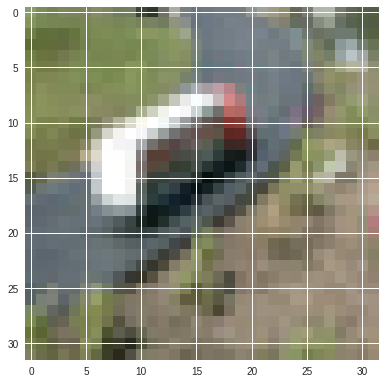

Prediction:  1 Actual:  8
[5.2503130e-04 9.9240327e-01 1.7935676e-07 1.1749857e-05 2.8905012e-11
 8.5920753e-08 3.9446856e-08 1.1996521e-11 7.0264493e-03 3.3278960e-05]


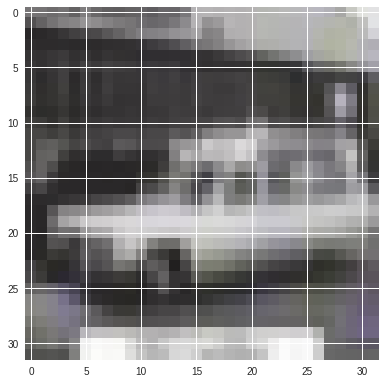

Prediction:  2 Actual:  0
[2.7037807e-02 2.8875224e-14 9.7280800e-01 5.5086197e-08 1.5398141e-04
 7.5190071e-10 2.4292797e-07 3.1595004e-11 1.2080653e-08 9.3491287e-15]


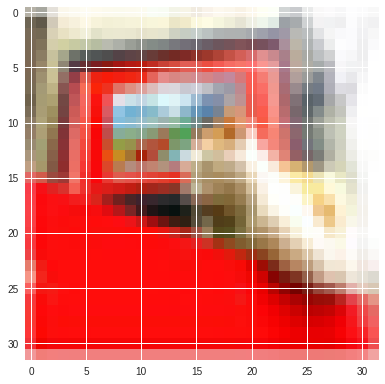

Prediction:  0 Actual:  4
[0.45807737 0.01643849 0.16190408 0.01799418 0.16930257 0.00288173
 0.09548997 0.00985941 0.02665478 0.04139736]


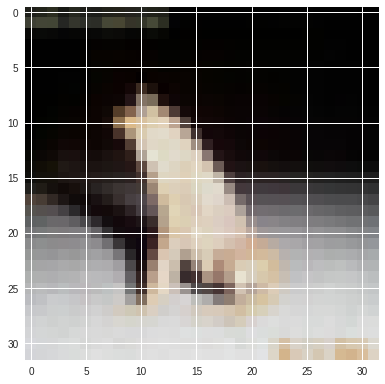

Prediction:  1 Actual:  9
[7.68830055e-10 6.28798842e-01 2.21941492e-17 1.48740568e-11
 1.93042684e-15 5.08000109e-13 1.34727169e-12 1.06995406e-10
 1.01731262e-10 3.71201187e-01]


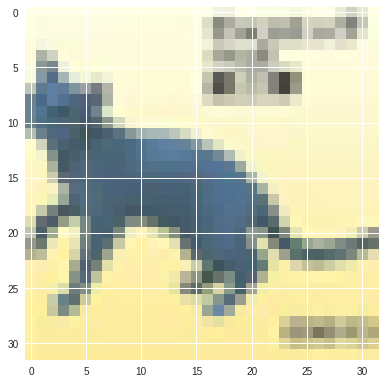

Prediction:  4 Actual:  5
[9.3558856e-04 1.6560017e-08 3.5421005e-01 8.3699943e-03 6.0824203e-01
 9.0466738e-03 1.1504023e-02 7.6888073e-03 1.7707576e-06 1.0692023e-06]


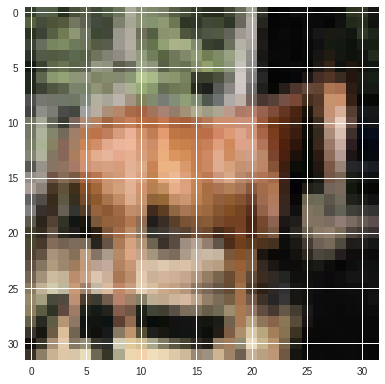

Prediction:  3 Actual:  2
[0.01500545 0.02390542 0.07007876 0.33133188 0.05304325 0.13695142
 0.32063553 0.01320939 0.01595424 0.01988469]


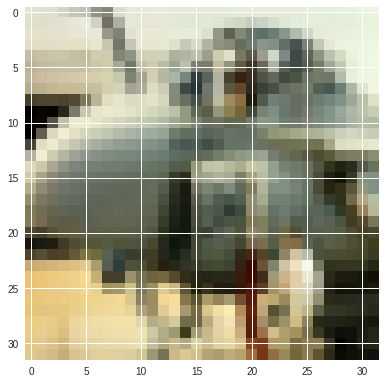

Prediction:  5 Actual:  4
[4.89938771e-03 3.92110414e-05 1.17093116e-01 1.60918087e-01
 4.18165587e-02 4.81553614e-01 1.06592721e-03 1.92372084e-01
 6.85263194e-06 2.35147832e-04]


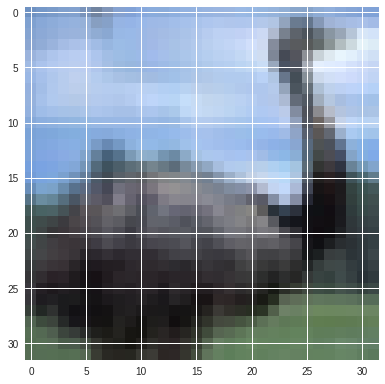

Prediction:  2 Actual:  0
[2.4008499e-01 1.1774653e-03 6.6530889e-01 2.9796068e-02 1.8567078e-02
 3.0452631e-02 2.2315735e-03 1.2003041e-02 9.3548748e-05 2.8460770e-04]


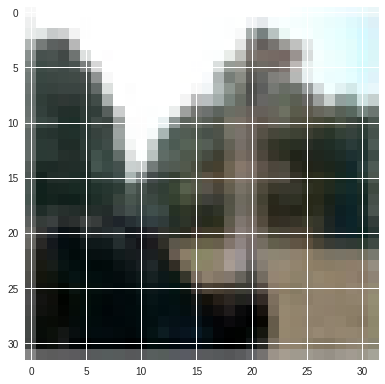

Prediction:  4 Actual:  5
[1.4125657e-03 9.1770806e-07 3.0526620e-01 6.4615339e-02 3.5667518e-01
 1.6346712e-01 5.5344333e-03 1.0298771e-01 1.7065317e-05 2.3383431e-05]


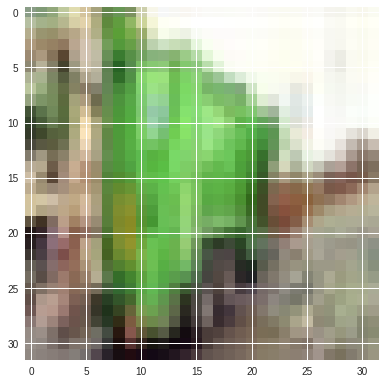

Prediction:  3 Actual:  5
[6.8606445e-05 1.0535979e-05 9.7206691e-03 6.5080285e-01 7.3856120e-03
 2.9793006e-01 3.3221930e-02 6.9511047e-04 1.2668890e-04 3.7928963e-05]


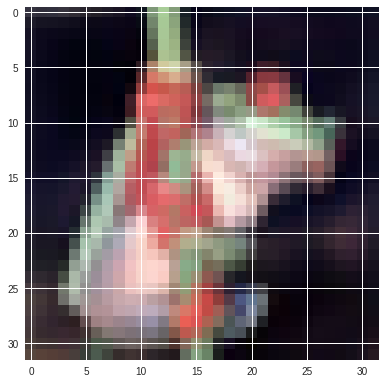

Prediction:  1 Actual:  2
[0.0206001  0.37451202 0.00475276 0.31319162 0.00230867 0.05940151
 0.01849316 0.00345921 0.02755366 0.17572723]


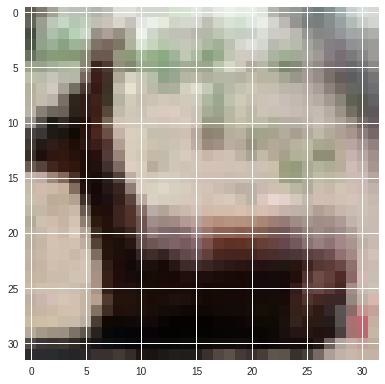

Prediction:  0 Actual:  4
[0.468558   0.00393609 0.14803828 0.04783402 0.11957379 0.00355036
 0.01898683 0.00345739 0.16503245 0.02103277]


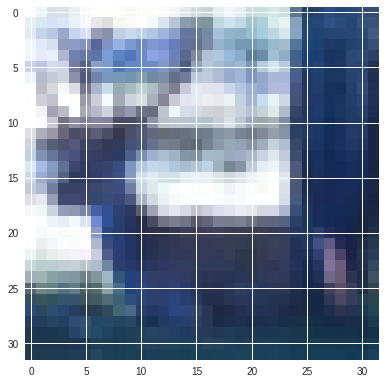

Prediction:  5 Actual:  3
[7.7922587e-06 4.4007038e-06 1.8733731e-03 3.7216935e-01 7.6876406e-04
 6.2301975e-01 7.7920663e-04 1.3502855e-03 1.6271049e-05 1.0918950e-05]


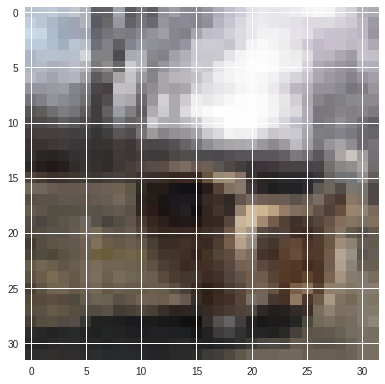

Prediction:  4 Actual:  7
[2.8452412e-05 2.4119535e-09 3.1019198e-02 5.0926744e-03 6.8649393e-01
 3.0781858e-02 2.1631310e-03 2.4441865e-01 3.8653504e-08 2.0437712e-06]


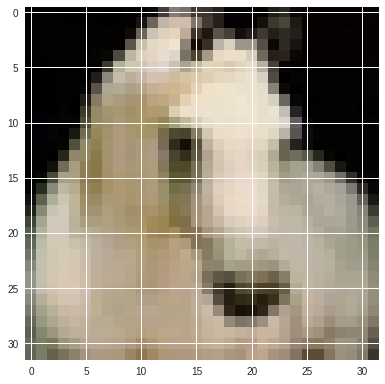

Prediction:  0 Actual:  9
[0.5822985  0.0400495  0.05006853 0.01483861 0.03515315 0.00550027
 0.00062519 0.07486986 0.04404323 0.15255308]


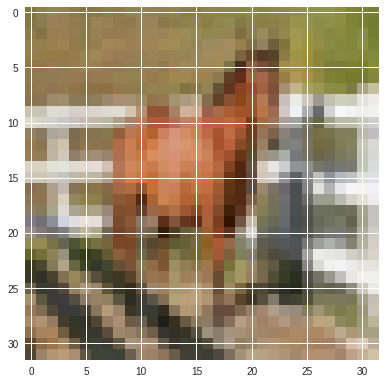

Prediction:  2 Actual:  0
[1.4234511e-03 8.2584875e-06 4.3171635e-01 7.1402602e-02 8.9611240e-02
 1.5175205e-01 2.4632849e-01 7.7490923e-03 8.5608553e-07 7.6374008e-06]


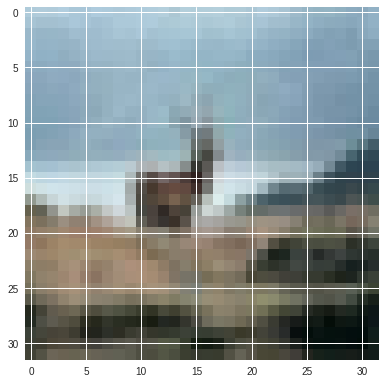

Prediction:  3 Actual:  7
[0.03416301 0.19965376 0.06719811 0.25039136 0.00868113 0.15302208
 0.01285565 0.0133056  0.23458284 0.02614652]


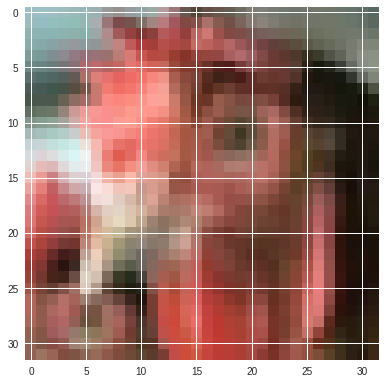

Prediction:  7 Actual:  4
[3.52412090e-03 4.25295118e-04 4.88604568e-02 1.16209544e-01
 1.10822178e-01 2.85914242e-01 1.38294520e-02 4.16140109e-01
 5.55490587e-05 4.21900349e-03]


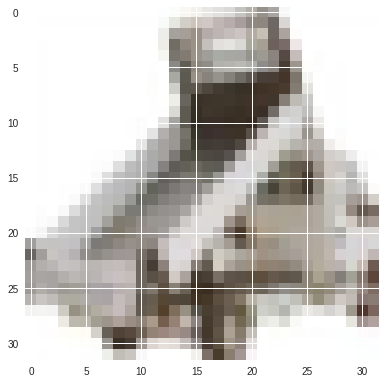

Prediction:  3 Actual:  6
[0.00172106 0.00172167 0.01487545 0.660382   0.02129055 0.20611683
 0.02206738 0.00662869 0.05820732 0.00698898]


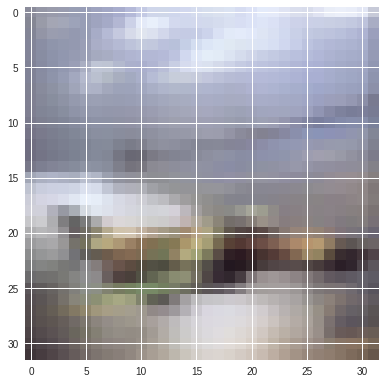

Prediction:  5 Actual:  3
[6.4116553e-03 1.4384837e-04 1.3589318e-01 3.0381492e-01 3.2485127e-02
 4.6927893e-01 8.8254362e-03 4.2834800e-02 1.3787632e-05 2.9833335e-04]


In [196]:
counter = 0
check_index = -1
while counter<20:
  check_index += 1
  check_logits, check_loss= tf_sess.run \
            (
                [logits, loss],
                feed_dict={inputs: [test_x[check_index]], 
                           labels: [test_y_oh[check_index]]}
            )
  prediction = np.argmax(check_logits)
  actual = np.argmax(test_y_oh[check_index])
  
  if prediction == actual:
    continue
    
  counter += 1
  draw_image(test_x[worst[check_index]], data_mean, data_std)
  print("Prediction: ", prediction,
        "Actual: ", actual)
  
  print(pred[check_index])